The sticky air method is a good way to simulate a free surface for Eulerian approaches, provided that its parameters are chosen carefully ($C\ll1$).

2.1.1 Isostatic timescale

$C_{isost}= \frac{3}{16\pi^{3}}(\frac{L}{h_{st}})^{3}\frac{\eta_{st}}{\eta_{ch}}$


2.1.2 Stokes timescale

$C_{Stokes}= \frac{1}{16}\frac{\Delta \rho }{\rho }(\frac{h_{model}}{h_{st}})^{3}\frac{\eta_{st}}{\eta_{ch}}$


This is the case2 in the reference, like fig.7 and fig.5

### Reference

- Crameri, F., Schmeling, H., Golabek, G. J., Duretz, T., Orendt, R., Buiter, S. J. H., ... & Tackley, P. J. (2012). A comparison of numerical surface topography calculations in geodynamic modelling: an evaluation of the ‘sticky air’method. Geophysical Journal International, 189(1), 38-54.

In [1]:
import underworld as uw
from underworld import function as fn
import underworld.visualisation as vis

from underworld.scaling import units as u
from underworld.scaling import dimensionalise 
from underworld.scaling import non_dimensionalise as nd

import math
import numpy as np
import os

In [2]:
# build reference units
KL_meters   = 850 * u.kilometer
K_viscosity = 1e21  * u.pascal * u.second
K_density   = 3300 * u.kilogram / u.meter**3

# compute dependent scaling units 
#KT_seconds = 1000*u.kiloyear
#KM_kilograms = KT_seconds * KL_meters * K_viscosity
KM_kilograms = K_density * KL_meters**3
KT_seconds   = KM_kilograms / ( KL_meters * K_viscosity )
K_substance  = 1. * u.mole
#Kt_degrees   = 1. * u.kelvin

scaling_coefficients = uw.scaling.get_coefficients()
scaling_coefficients["[length]"]      = KL_meters.to_base_units()
#scaling_coefficients["[temperature]"] = Kt_degrees.to_base_units()
scaling_coefficients["[time]"]        = KT_seconds.to_base_units()
scaling_coefficients["[mass]"]        = KM_kilograms.to_base_units()

gravity = nd(10. * u.meter / u.second**2)

ymaxCoord = nd(850.* u.kilometer)
yminCoord = nd(0.* u.kilometer)
xmaxCoord = nd(2800.* u.kilometer)
xminCoord = nd(0.* u.kilometer)

In [3]:
# In the present Case 2, the relaxation time is about 15 ka 
DT = nd(2.5e3*u.year) #DT = nd(5e4*u.year)

maxSteps   = int(nd(4e6*u.year)/DT+1)
steps_output = int(nd(0.5e6*u.year)/DT)

xRes,yRes        = 560,340
RESTART = 0

# output
outputPath ="Crameri2012Case2_withVo_2.5ka/"

# search and build, if required, an output path
if uw.mpi.rank==0:
    try:
        if not os.path.exists("./"+outputPath+"/"):
            os.makedirs("./"+outputPath+'/')
    except:
        raise
        
bufsize=0
outfile = open(outputPath+'time.txt', 'wb',bufsize)

In [4]:
# build mesh and mesh variables
mesh = uw.mesh.FeMesh_Cartesian( elementType = 'Q1/dQ0', 
                                 elementRes  = (xRes, yRes), 
                                 minCoord    = [xminCoord,yminCoord], 
                                 maxCoord    = [xmaxCoord,ymaxCoord],
                                 periodic    = [False, False])

velocityField   = uw.mesh.MeshVariable( mesh=mesh,         nodeDofCount=mesh.dim )
pressureField   = uw.mesh.MeshVariable( mesh=mesh.subMesh, nodeDofCount=1 )

velocityField.data[:] = [0.,0.]
pressureField.data[:] = 0.

In [5]:
# Create a swarm.
hmax =  1.0  #nd(850* u.kilometer)
hw = nd(150.* u.kilometer)
hLith = nd(100.* u.kilometer)
rPlume = nd(50.* u.kilometer)  
x0Plume = nd(1400.* u.kilometer) 
y0Plume =  nd(300.* u.kilometer)

swarm = uw.swarm.Swarm( mesh=mesh,particleEscape=True)
swarm2 = uw.swarm.Swarm( mesh=mesh, particleEscape=True)

materialVariable   = swarm.add_variable( dataType="int", count=1 )
# if (RESTART == 1):
#         swarm.load(inputPath+"swarm"+ str(step).zfill(4)+".h5")
#         swarm2.load(inputPath+"surfaceSwarm"+ str(step).zfill(4)+".h5")
#         materialVariable.load(inputPath+"material"+ str(step).zfill(4)+".h5")

# else:
swarmLayout = uw.swarm.layouts.PerCellSpaceFillerLayout( swarm=swarm, particlesPerCell=36 )
#swarmLayout = uw.swarm.layouts.GlobalSpaceFillerLayout( swarm=swarm, particlesPerCell=20 )
swarm.populate_using_layout( layout=swarmLayout )

surfacePoints = np.zeros((5000,2))
surfacePoints[:,0] = np.linspace(xminCoord, xmaxCoord, 5000)
for index in range( len(surfacePoints[:,0]) ):
    surfacePoints[index,1] = hmax-hw

swarm2.add_particles_with_coordinates(surfacePoints)


# create pop control object
#pop_control = uw.swarm.PopulationControl(swarm, deleteThreshold=0.025, splitThreshold=0.2,particlesPerCell=36)
pop_control = uw.swarm.PopulationControl(swarm,aggressive=True,splitThreshold=0.15, maxDeletions=2,maxSplits=10,particlesPerCell=36)

In [6]:
# Allocate materials to particles
MantleIndex = 0
LithIndex   = 1
PlumeIndex = 2
AirIndex = 3

#if (RESTART == 0):
    # initialise everying to be upper mantle material
materialVariable.data[:] = MantleIndex

# change matieral index if the particle is not mantle
for index in range( len(swarm.particleCoordinates.data) ):
    coord = swarm.particleCoordinates.data[index][:]
    if math.sqrt((coord[0]-x0Plume)**2+(coord[1]-y0Plume)**2) < rPlume:
        materialVariable.data[index]     = PlumeIndex
    elif coord[1] > hmax-hw-hLith:
        if coord[1] < hmax-hw:
            materialVariable.data[index]     = LithIndex
        else:
            materialVariable.data[index]     = AirIndex


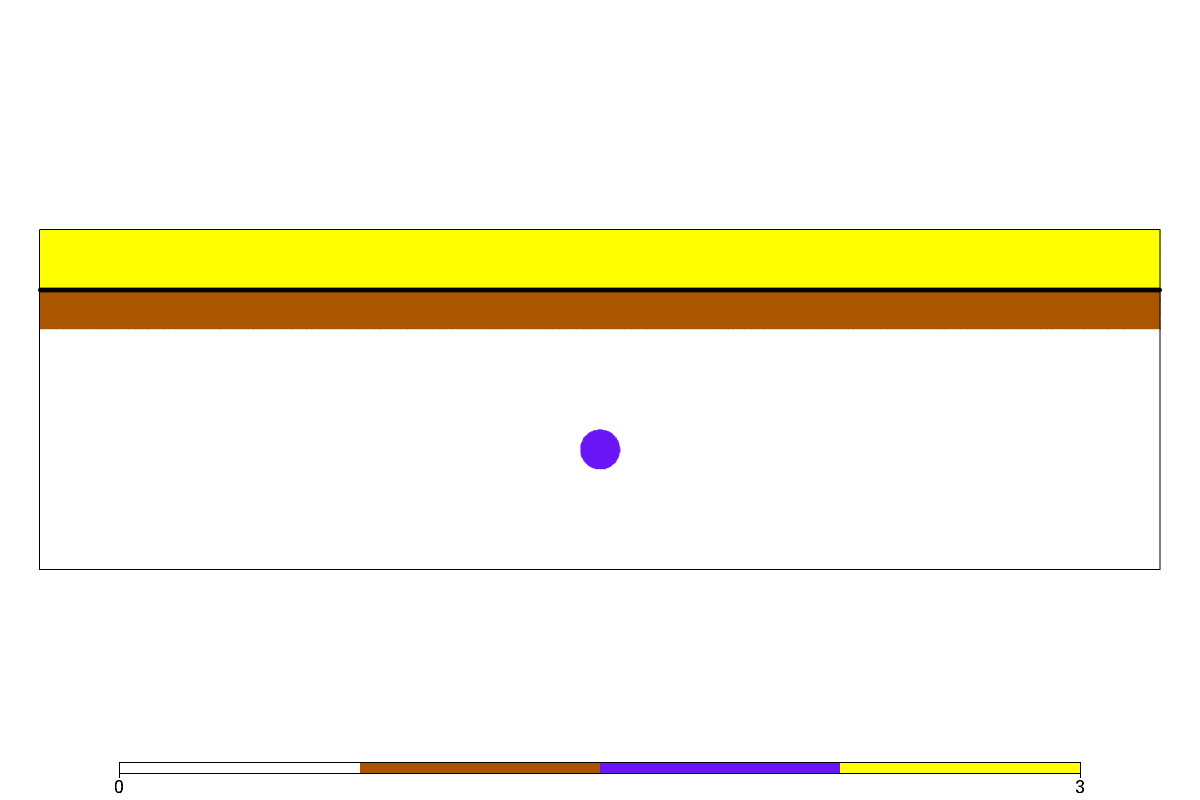

In [7]:
# Plot the initial positions for the particle swarm and colour by material type
figParticle = vis.Figure( figsize=(1200,800),quality=2)
figParticle.append (vis.objects.Points(swarm2,pointSize=5, colourBar=False))
figParticle.append( vis.objects.Points(swarm, materialVariable, pointSize=2, colours='white green red purple blue yellow',discrete=True) )
figParticle.show()

In [8]:
# **Viscosity function**
visosity_mantle = nd(1e21 * u.pascal * u.second)
visosity_plume = nd(1e20 * u.pascal * u.second)
visosity_lith = nd(1e23 * u.pascal * u.second)
visosity_air = nd(1e19 * u.pascal * u.second)


strainRateFn = fn.tensor.symmetric( velocityField.fn_gradient )
strainRate_2ndInvariant = fn.tensor.second_invariant( strainRateFn )

coord = fn.input()
viscosityMap = {LithIndex:visosity_lith, 
                MantleIndex:visosity_mantle, 
                PlumeIndex:visosity_plume, 
                AirIndex:visosity_air}


viscosityFn   = fn.branching.map( fn_key = materialVariable,
                                           mapping = viscosityMap )

devStressFn = 2.0 * viscosityFn * strainRateFn

In [9]:
# **Set the density function, vertical unit vector and Buoyancy Force function**
density_mantle = nd(3300. * u.kilogram / u.meter**3)
density_plume = nd(3200. * u.kilogram / u.meter**3)
density_lith = nd(3300. * u.kilogram / u.meter**3)
density_air = nd(0. * u.kilogram / u.meter**3)

densityMap = { LithIndex:density_lith,
              MantleIndex:density_mantle,
              PlumeIndex:density_plume,
              AirIndex:density_air}

densityFn = fn.branching.map( fn_key=materialVariable, mapping=densityMap ) 
# And the final buoyancy force function.
z_hat = ( 0.0, -1.0 )

buoyancyFn = densityFn * z_hat*gravity
#buoyancyFn = ( 0.0, -1.0 )

# figbuoyancy = glucifer.Figure( figsize=(1200,800),quality=2)
# figbuoyancy.append( glucifer.objects.Points(swarm, densityFn, pointSize=3.0, valueRange=None,
#                                                      colours="red yellow blue", logScale=False) )
# figbuoyancy.show()

In [10]:
# **Set initial and boundary conditions**

leftrightWalls = mesh.specialSets['Left_VertexSet'] + mesh.specialSets['Right_VertexSet']
topWalls  = mesh.specialSets[ 'Top_VertexSet'] 

bottWalls = mesh.specialSets['Bottom_VertexSet']
VelBC = uw.conditions.DirichletCondition(velocityField, (leftrightWalls+bottWalls,topWalls+bottWalls))

In [11]:
# **System and solver Setup**

stokes = uw.systems.Stokes(    velocityField = velocityField,
                               pressureField = pressureField,
                               voronoi_swarm = swarm,
                               conditions    = VelBC,
                               fn_viscosity  = viscosityFn,
                               fn_bodyforce  = buoyancyFn )


solver = uw.systems.Solver(stokes)

# "mumps" is a good alternative for "lu" but 
# not every petsc installation has mumps !
# It also works fine in parallel
# if LargePenalty == 1:
#     solver.set_penalty(1.0e6)
#     solver.set_inner_method("mumps")
#     # use "lu" direct solve and large penalty (if running in serial)
#     #if(uw.nProcs()==1):
#     #    solver.set_inner_method("lu")
# else:
#     solver.set_penalty(1.0e2)
#     solver.set_inner_method("mg")
#     solver.options.mg.levels = 6
#solver.options.scr.ksp_rtol=1.0e-8

# Optional solver settings
# if(uw.mpi.size==1):
solver.set_inner_method("lu")
stokes_inner_tol = 1e-6
stokes_outer_tol = 1e-5
solver.set_inner_rtol(stokes_inner_tol) 
solver.set_outer_rtol(stokes_outer_tol) 
solver.set_penalty(0.0)

#solver.set_penalty(1.0e6)

# solver.set_penalty(1.0e6)
# solver.set_inner_method("mumps")
# solver.options.scr.ksp_rtol=1.0e-8
    
advector = uw.systems.SwarmAdvector( swarm=swarm, velocityField=velocityField, order=2 )
advector2 = uw.systems.SwarmAdvector( swarm=swarm2, velocityField=velocityField, order=2 )

In [12]:
# **Main simulation loop**
# define an update function

meshFileHandle = mesh.save(outputPath+"Mesh.h5")

def update():
    # Retrieve the maximum possible timestep for the advection system.
    #uw.barrier()
    dt1 = advector.get_max_dt()
    dt = DT
    # Advect using this timestep size.
    advector.integrate(dt,update_owners=True)
    advector2.integrate(dt,update_owners=True)

    # particle population control
    #if (step%5 ==0):
    pop_control.repopulate()
    #uw.barrier()

    if (step%steps_output ==0):
        mHnd=mesh.save(outputPath+"mesh"+ str(step).zfill(4)+".h5")
        #s1Hnd=swarm.save(outputPath+"swarm"+ str(step).zfill(4)+".h5")
        swarm2.save(outputPath+"surfaceSwarm"+ str(step).zfill(4)+".h5")
        matHnd=materialVariable.save(outputPath+"material"+ str(step).zfill(4)+".h5")        
         
        filename = outputPath+"velocityField."+str(step).zfill(4)
        vFH      = velocityField.save(filename+".h5")
        velocityField.xdmf( filename, vFH, "velocity", meshFileHandle, "Mesh", time )
        
        filename = outputPath+"pressureField."+str(step).zfill(4)
        pFH      = pressureField.save(filename+".h5")
        pressureField.xdmf(filename, pFH, "pressure", meshFileHandle, "Mesh", time )
        
        outputFilename = outputPath+"image"+str(step).zfill(4)
        figParticle.save_image(outputFilename)
        
    return dt, time+dt, step+1

In [13]:
# add velocity BC for stokes solver
dtStep=0.0
step = 0
time = 0.0
while step < maxSteps:
    # Solve non linear Stokes system
    #solver.solve(nonLinearIterate=True,nonLinearMaxIterations=200,nonLinearTolerance=0.003)
    solver.solve(nonLinearIterate=False)
    solver.print_stats()


    # output figure to file at intervals = steps_output
    #if uw.rank()==0:
    print('step = {0:6d}; time = {1:.3e}; dt = {1:.3e}'.format(step,dimensionalise(time, u.kiloyear),dimensionalise(dtStep, u.kiloyear)))
    string = "{0}; {1:.3e}; {1:.3e}\n".format(step,dimensionalise(time, u.kiloyear).m,dimensionalise(dtStep, u.kiloyear).m)
    outfile.write(string.encode())
    # update
    dtStep,time,step = update()


 
Pressure iterations:  16
Velocity iterations:   1 (presolve)      
Velocity iterations:  16 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  18 (total solve)   
 
SCR RHS  setup time: 1.4773e+01
SCR RHS  solve time: 1.2921e-01
Pressure setup time: 3.0287e-02
Pressure solve time: 2.5206e+00
Velocity setup time: 6.2800e-07 (backsolve)
Velocity solve time: 1.4074e-01 (backsolve)
Total solve time   : 1.7767e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =      0; time = 0.000e+00 kiloyear; dt = 0.000e+00 kiloyear

 
Pressure iterations:  36
Velocity iterations:   1 (presolve)      
Velocity iterations:  37 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  39 (total solve)   
 
SCR RHS  setup time: 1.5045e+01
SCR RHS  solve time: 1.0965e-01
Pressure setup time: 2.6614e-02
Pressure solve time: 5.2566e+00
Velocity setup time: 8.3300e-07 (backsolve)
Velocity solve 


 
Pressure iterations:  36
Velocity iterations:   1 (presolve)      
Velocity iterations:  37 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  39 (total solve)   
 
SCR RHS  setup time: 2.0285e+01
SCR RHS  solve time: 9.8488e-02
Pressure setup time: 2.9075e-02
Pressure solve time: 5.0482e+00
Velocity setup time: 6.2400e-07 (backsolve)
Velocity solve time: 1.6566e-01 (backsolve)
Total solve time   : 2.5749e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =     14; time = 3.500e+01 kiloyear; dt = 3.500e+01 kiloyear

 
Pressure iterations:  35
Velocity iterations:   1 (presolve)      
Velocity iterations:  36 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  38 (total solve)   
 
SCR RHS  setup time: 1.6472e+01
SCR RHS  solve time: 1.0393e-01
Pressure setup time: 2.8350e-02
Pressure solve time: 5.2037e+00
Velocity setup time: 9.2000e-07 (backsolve)
Velocity solve 


 
Pressure iterations:  36
Velocity iterations:   1 (presolve)      
Velocity iterations:  37 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  39 (total solve)   
 
SCR RHS  setup time: 2.2423e+01
SCR RHS  solve time: 1.0394e-01
Pressure setup time: 2.8727e-02
Pressure solve time: 4.8108e+00
Velocity setup time: 7.7700e-07 (backsolve)
Velocity solve time: 1.6962e-01 (backsolve)
Total solve time   : 2.7675e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =     28; time = 7.000e+01 kiloyear; dt = 7.000e+01 kiloyear

 
Pressure iterations:  36
Velocity iterations:   1 (presolve)      
Velocity iterations:  37 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  39 (total solve)   
 
SCR RHS  setup time: 1.9302e+01
SCR RHS  solve time: 1.1248e-01
Pressure setup time: 2.8025e-02
Pressure solve time: 5.1610e+00
Velocity setup time: 1.1610e-06 (backsolve)
Velocity solve 


 
Pressure iterations:  38
Velocity iterations:   1 (presolve)      
Velocity iterations:  39 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  41 (total solve)   
 
SCR RHS  setup time: 3.9083e+01
SCR RHS  solve time: 2.3202e-01
Pressure setup time: 9.9112e-02
Pressure solve time: 1.2113e+01
Velocity setup time: 1.1530e-06 (backsolve)
Velocity solve time: 1.4833e-01 (backsolve)
Total solve time   : 5.1929e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =     42; time = 1.050e+02 kiloyear; dt = 1.050e+02 kiloyear

 
Pressure iterations:  38
Velocity iterations:   1 (presolve)      
Velocity iterations:  39 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  41 (total solve)   
 
SCR RHS  setup time: 2.6926e+01
SCR RHS  solve time: 2.5299e-01
Pressure setup time: 4.6737e-02
Pressure solve time: 8.7357e+00
Velocity setup time: 6.4000e-07 (backsolve)
Velocity solve 


 
Pressure iterations:  29
Velocity iterations:   1 (presolve)      
Velocity iterations:  29 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  31 (total solve)   
 
SCR RHS  setup time: 1.7499e+01
SCR RHS  solve time: 1.2349e-01
Pressure setup time: 2.9955e-02
Pressure solve time: 4.1204e+00
Velocity setup time: 1.0500e-06 (backsolve)
Velocity solve time: 1.2509e-01 (backsolve)
Total solve time   : 2.2027e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =     56; time = 1.400e+02 kiloyear; dt = 1.400e+02 kiloyear

 
Pressure iterations:  29
Velocity iterations:   1 (presolve)      
Velocity iterations:  29 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  31 (total solve)   
 
SCR RHS  setup time: 1.6089e+01
SCR RHS  solve time: 1.1348e-01
Pressure setup time: 3.0426e-02
Pressure solve time: 4.1355e+00
Velocity setup time: 7.6200e-07 (backsolve)
Velocity solve 


 
Pressure iterations:  30
Velocity iterations:   1 (presolve)      
Velocity iterations:  30 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  32 (total solve)   
 
SCR RHS  setup time: 2.0063e+01
SCR RHS  solve time: 8.8253e-02
Pressure setup time: 2.9396e-02
Pressure solve time: 3.8081e+00
Velocity setup time: 5.4600e-07 (backsolve)
Velocity solve time: 1.1695e-01 (backsolve)
Total solve time   : 2.4230e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =     70; time = 1.750e+02 kiloyear; dt = 1.750e+02 kiloyear

 
Pressure iterations:  30
Velocity iterations:   1 (presolve)      
Velocity iterations:  30 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  32 (total solve)   
 
SCR RHS  setup time: 1.8655e+01
SCR RHS  solve time: 1.3752e-01
Pressure setup time: 3.0263e-02
Pressure solve time: 4.3055e+00
Velocity setup time: 9.5300e-07 (backsolve)
Velocity solve 


 
Pressure iterations:  28
Velocity iterations:   1 (presolve)      
Velocity iterations:  28 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  30 (total solve)   
 
SCR RHS  setup time: 2.6789e+01
SCR RHS  solve time: 2.0879e-01
Pressure setup time: 4.2177e-02
Pressure solve time: 6.5905e+00
Velocity setup time: 7.5400e-07 (backsolve)
Velocity solve time: 1.2627e-01 (backsolve)
Total solve time   : 3.3947e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =     84; time = 2.100e+02 kiloyear; dt = 2.100e+02 kiloyear

 
Pressure iterations:  28
Velocity iterations:   1 (presolve)      
Velocity iterations:  28 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  30 (total solve)   
 
SCR RHS  setup time: 2.2777e+01
SCR RHS  solve time: 1.1127e-01
Pressure setup time: 3.5966e-02
Pressure solve time: 3.9995e+00
Velocity setup time: 1.0390e-06 (backsolve)
Velocity solve 


 
Pressure iterations:  28
Velocity iterations:   1 (presolve)      
Velocity iterations:  28 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  30 (total solve)   
 
SCR RHS  setup time: 2.3999e+01
SCR RHS  solve time: 1.1450e-01
Pressure setup time: 3.3556e-02
Pressure solve time: 4.0102e+00
Velocity setup time: 7.4300e-07 (backsolve)
Velocity solve time: 1.2470e-01 (backsolve)
Total solve time   : 2.8420e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =     98; time = 2.450e+02 kiloyear; dt = 2.450e+02 kiloyear

 
Pressure iterations:  28
Velocity iterations:   1 (presolve)      
Velocity iterations:  28 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  30 (total solve)   
 
SCR RHS  setup time: 2.2235e+01
SCR RHS  solve time: 1.1426e-01
Pressure setup time: 3.2594e-02
Pressure solve time: 4.1609e+00
Velocity setup time: 8.4200e-07 (backsolve)
Velocity solve 


 
Pressure iterations:  27
Velocity iterations:   1 (presolve)      
Velocity iterations:  27 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  29 (total solve)   
 
SCR RHS  setup time: 1.9704e+01
SCR RHS  solve time: 1.5170e-01
Pressure setup time: 6.5205e-02
Pressure solve time: 4.8578e+00
Velocity setup time: 1.3350e-06 (backsolve)
Velocity solve time: 1.4987e-01 (backsolve)
Total solve time   : 2.5096e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =    112; time = 2.800e+02 kiloyear; dt = 2.800e+02 kiloyear

 
Pressure iterations:  27
Velocity iterations:   1 (presolve)      
Velocity iterations:  27 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  29 (total solve)   
 
SCR RHS  setup time: 2.3030e+01
SCR RHS  solve time: 1.6314e-01
Pressure setup time: 2.9651e-02
Pressure solve time: 4.8156e+00
Velocity setup time: 6.3700e-07 (backsolve)
Velocity solve 


 
Pressure iterations:  27
Velocity iterations:   1 (presolve)      
Velocity iterations:  27 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  29 (total solve)   
 
SCR RHS  setup time: 2.0348e+01
SCR RHS  solve time: 1.1027e-01
Pressure setup time: 3.2684e-02
Pressure solve time: 3.9788e+00
Velocity setup time: 2.0610e-06 (backsolve)
Velocity solve time: 1.3771e-01 (backsolve)
Total solve time   : 2.4742e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =    126; time = 3.150e+02 kiloyear; dt = 3.150e+02 kiloyear

 
Pressure iterations:  27
Velocity iterations:   1 (presolve)      
Velocity iterations:  27 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  29 (total solve)   
 
SCR RHS  setup time: 1.7977e+01
SCR RHS  solve time: 1.3139e-01
Pressure setup time: 3.1608e-02
Pressure solve time: 4.5448e+00
Velocity setup time: 1.7020e-06 (backsolve)
Velocity solve 


 
Pressure iterations:  27
Velocity iterations:   1 (presolve)      
Velocity iterations:  27 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  29 (total solve)   
 
SCR RHS  setup time: 2.2231e+01
SCR RHS  solve time: 1.8546e-01
Pressure setup time: 3.5238e-02
Pressure solve time: 5.2233e+00
Velocity setup time: 8.9700e-07 (backsolve)
Velocity solve time: 1.2200e-01 (backsolve)
Total solve time   : 2.7971e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =    140; time = 3.500e+02 kiloyear; dt = 3.500e+02 kiloyear

 
Pressure iterations:  27
Velocity iterations:   1 (presolve)      
Velocity iterations:  27 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  29 (total solve)   
 
SCR RHS  setup time: 2.2445e+01
SCR RHS  solve time: 1.1398e-01
Pressure setup time: 6.6177e-02
Pressure solve time: 3.9099e+00
Velocity setup time: 1.0300e-06 (backsolve)
Velocity solve 


 
Pressure iterations:  28
Velocity iterations:   1 (presolve)      
Velocity iterations:  28 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  30 (total solve)   
 
SCR RHS  setup time: 1.8203e+01
SCR RHS  solve time: 1.5408e-01
Pressure setup time: 3.3056e-02
Pressure solve time: 4.8825e+00
Velocity setup time: 1.6470e-06 (backsolve)
Velocity solve time: 1.5084e-01 (backsolve)
Total solve time   : 2.3588e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =    154; time = 3.850e+02 kiloyear; dt = 3.850e+02 kiloyear

 
Pressure iterations:  28
Velocity iterations:   1 (presolve)      
Velocity iterations:  28 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  30 (total solve)   
 
SCR RHS  setup time: 1.9339e+01
SCR RHS  solve time: 1.5243e-01
Pressure setup time: 2.9447e-02
Pressure solve time: 5.1012e+00
Velocity setup time: 8.1200e-07 (backsolve)
Velocity solve 


 
Pressure iterations:  26
Velocity iterations:   1 (presolve)      
Velocity iterations:  26 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  28 (total solve)   
 
SCR RHS  setup time: 2.3134e+01
SCR RHS  solve time: 1.8449e-01
Pressure setup time: 8.9079e-02
Pressure solve time: 5.0287e+00
Velocity setup time: 6.9400e-07 (backsolve)
Velocity solve time: 1.2358e-01 (backsolve)
Total solve time   : 2.8732e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =    168; time = 4.200e+02 kiloyear; dt = 4.200e+02 kiloyear

 
Pressure iterations:  26
Velocity iterations:   1 (presolve)      
Velocity iterations:  26 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  28 (total solve)   
 
SCR RHS  setup time: 2.2998e+01
SCR RHS  solve time: 1.1456e-01
Pressure setup time: 3.0036e-02
Pressure solve time: 3.7709e+00
Velocity setup time: 7.3900e-07 (backsolve)
Velocity solve 


 
Pressure iterations:  26
Velocity iterations:   1 (presolve)      
Velocity iterations:  26 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  28 (total solve)   
 
SCR RHS  setup time: 1.7887e+01
SCR RHS  solve time: 1.3158e-01
Pressure setup time: 3.7391e-02
Pressure solve time: 4.6803e+00
Velocity setup time: 6.7300e-07 (backsolve)
Velocity solve time: 1.3077e-01 (backsolve)
Total solve time   : 2.3016e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =    182; time = 4.550e+02 kiloyear; dt = 4.550e+02 kiloyear

 
Pressure iterations:  26
Velocity iterations:   1 (presolve)      
Velocity iterations:  26 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  28 (total solve)   
 
SCR RHS  setup time: 1.8668e+01
SCR RHS  solve time: 1.1251e-01
Pressure setup time: 6.4190e-02
Pressure solve time: 3.6560e+00
Velocity setup time: 8.7200e-07 (backsolve)
Velocity solve 


 
Pressure iterations:  27
Velocity iterations:   1 (presolve)      
Velocity iterations:  27 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  29 (total solve)   
 
SCR RHS  setup time: 1.7986e+01
SCR RHS  solve time: 8.6199e-02
Pressure setup time: 2.7407e-02
Pressure solve time: 3.3227e+00
Velocity setup time: 6.8500e-07 (backsolve)
Velocity solve time: 1.2266e-01 (backsolve)
Total solve time   : 2.1658e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =    196; time = 4.900e+02 kiloyear; dt = 4.900e+02 kiloyear

 
Pressure iterations:  27
Velocity iterations:   1 (presolve)      
Velocity iterations:  27 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  29 (total solve)   
 
SCR RHS  setup time: 1.4995e+01
SCR RHS  solve time: 8.8428e-02
Pressure setup time: 2.6948e-02
Pressure solve time: 3.4431e+00
Velocity setup time: 1.0490e-06 (backsolve)
Velocity solve 


 
Pressure iterations:  27
Velocity iterations:   1 (presolve)      
Velocity iterations:  27 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  29 (total solve)   
 
SCR RHS  setup time: 1.7484e+01
SCR RHS  solve time: 8.6878e-02
Pressure setup time: 4.8151e-02
Pressure solve time: 3.2282e+00
Velocity setup time: 5.9800e-07 (backsolve)
Velocity solve time: 1.0540e-01 (backsolve)
Total solve time   : 2.1066e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =    210; time = 5.250e+02 kiloyear; dt = 5.250e+02 kiloyear

 
Pressure iterations:  27
Velocity iterations:   1 (presolve)      
Velocity iterations:  27 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  29 (total solve)   
 
SCR RHS  setup time: 1.4741e+01
SCR RHS  solve time: 1.0967e-01
Pressure setup time: 2.5904e-02
Pressure solve time: 3.4283e+00
Velocity setup time: 5.2300e-07 (backsolve)
Velocity solve 


 
Pressure iterations:  27
Velocity iterations:   1 (presolve)      
Velocity iterations:  27 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  29 (total solve)   
 
SCR RHS  setup time: 1.8646e+01
SCR RHS  solve time: 8.8108e-02
Pressure setup time: 2.5647e-02
Pressure solve time: 3.2888e+00
Velocity setup time: 6.3100e-07 (backsolve)
Velocity solve time: 1.0640e-01 (backsolve)
Total solve time   : 2.2263e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =    224; time = 5.600e+02 kiloyear; dt = 5.600e+02 kiloyear

 
Pressure iterations:  27
Velocity iterations:   1 (presolve)      
Velocity iterations:  27 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  29 (total solve)   
 
SCR RHS  setup time: 1.7462e+01
SCR RHS  solve time: 8.5770e-02
Pressure setup time: 2.4183e-02
Pressure solve time: 3.2553e+00
Velocity setup time: 5.6700e-07 (backsolve)
Velocity solve 


 
Pressure iterations:  27
Velocity iterations:   1 (presolve)      
Velocity iterations:  27 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  29 (total solve)   
 
SCR RHS  setup time: 1.5772e+01
SCR RHS  solve time: 1.1254e-01
Pressure setup time: 2.5172e-02
Pressure solve time: 4.6298e+00
Velocity setup time: 9.7800e-07 (backsolve)
Velocity solve time: 1.3724e-01 (backsolve)
Total solve time   : 2.0817e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =    238; time = 5.950e+02 kiloyear; dt = 5.950e+02 kiloyear

 
Pressure iterations:  27
Velocity iterations:   1 (presolve)      
Velocity iterations:  27 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  29 (total solve)   
 
SCR RHS  setup time: 1.8733e+01
SCR RHS  solve time: 8.6950e-02
Pressure setup time: 2.4768e-02
Pressure solve time: 3.2848e+00
Velocity setup time: 6.3800e-07 (backsolve)
Velocity solve 


 
Pressure iterations:  28
Velocity iterations:   1 (presolve)      
Velocity iterations:  28 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  30 (total solve)   
 
SCR RHS  setup time: 1.5154e+01
SCR RHS  solve time: 1.0807e-01
Pressure setup time: 2.4889e-02
Pressure solve time: 3.8841e+00
Velocity setup time: 7.4000e-07 (backsolve)
Velocity solve time: 1.2156e-01 (backsolve)
Total solve time   : 1.9414e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =    252; time = 6.300e+02 kiloyear; dt = 6.300e+02 kiloyear

 
Pressure iterations:  28
Velocity iterations:   1 (presolve)      
Velocity iterations:  28 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  30 (total solve)   
 
SCR RHS  setup time: 1.5844e+01
SCR RHS  solve time: 1.1152e-01
Pressure setup time: 2.6750e-02
Pressure solve time: 4.8237e+00
Velocity setup time: 1.5010e-06 (backsolve)
Velocity solve 


 
Pressure iterations:  28
Velocity iterations:   1 (presolve)      
Velocity iterations:  28 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  30 (total solve)   
 
SCR RHS  setup time: 1.4832e+01
SCR RHS  solve time: 9.5031e-02
Pressure setup time: 5.0618e-02
Pressure solve time: 3.8560e+00
Velocity setup time: 6.3600e-07 (backsolve)
Velocity solve time: 1.2132e-01 (backsolve)
Total solve time   : 1.9084e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =    266; time = 6.650e+02 kiloyear; dt = 6.650e+02 kiloyear

 
Pressure iterations:  28
Velocity iterations:   1 (presolve)      
Velocity iterations:  28 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  30 (total solve)   
 
SCR RHS  setup time: 1.5434e+01
SCR RHS  solve time: 1.1240e-01
Pressure setup time: 2.5318e-02
Pressure solve time: 3.8372e+00
Velocity setup time: 8.7800e-07 (backsolve)
Velocity solve 


 
Pressure iterations:  26
Velocity iterations:   1 (presolve)      
Velocity iterations:  26 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  28 (total solve)   
 
SCR RHS  setup time: 1.7878e+01
SCR RHS  solve time: 1.0808e-01
Pressure setup time: 2.7326e-02
Pressure solve time: 3.7132e+00
Velocity setup time: 6.3400e-07 (backsolve)
Velocity solve time: 1.6024e-01 (backsolve)
Total solve time   : 2.2035e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =    280; time = 7.000e+02 kiloyear; dt = 7.000e+02 kiloyear

 
Pressure iterations:  26
Velocity iterations:   1 (presolve)      
Velocity iterations:  26 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  28 (total solve)   
 
SCR RHS  setup time: 1.6674e+01
SCR RHS  solve time: 1.2712e-01
Pressure setup time: 2.8155e-02
Pressure solve time: 3.7027e+00
Velocity setup time: 5.7000e-07 (backsolve)
Velocity solve 


 
Pressure iterations:  26
Velocity iterations:   1 (presolve)      
Velocity iterations:  26 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  28 (total solve)   
 
SCR RHS  setup time: 1.9771e+01
SCR RHS  solve time: 9.0788e-02
Pressure setup time: 2.5320e-02
Pressure solve time: 3.1691e+00
Velocity setup time: 6.3300e-07 (backsolve)
Velocity solve time: 1.0896e-01 (backsolve)
Total solve time   : 2.3280e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =    294; time = 7.350e+02 kiloyear; dt = 7.350e+02 kiloyear

 
Pressure iterations:  26
Velocity iterations:   1 (presolve)      
Velocity iterations:  26 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  28 (total solve)   
 
SCR RHS  setup time: 1.8532e+01
SCR RHS  solve time: 9.0797e-02
Pressure setup time: 2.6207e-02
Pressure solve time: 3.1937e+00
Velocity setup time: 5.8600e-07 (backsolve)
Velocity solve 


 
Pressure iterations:  26
Velocity iterations:   1 (presolve)      
Velocity iterations:  26 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  28 (total solve)   
 
SCR RHS  setup time: 1.9421e+01
SCR RHS  solve time: 1.0621e-01
Pressure setup time: 2.5778e-02
Pressure solve time: 3.9007e+00
Velocity setup time: 1.0260e-06 (backsolve)
Velocity solve time: 1.4106e-01 (backsolve)
Total solve time   : 2.3744e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =    308; time = 7.700e+02 kiloyear; dt = 7.700e+02 kiloyear

 
Pressure iterations:  26
Velocity iterations:   1 (presolve)      
Velocity iterations:  26 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  28 (total solve)   
 
SCR RHS  setup time: 1.7448e+01
SCR RHS  solve time: 1.1209e-01
Pressure setup time: 2.9191e-02
Pressure solve time: 5.6908e+00
Velocity setup time: 7.0900e-07 (backsolve)
Velocity solve 


 
Pressure iterations:  26
Velocity iterations:   1 (presolve)      
Velocity iterations:  26 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  28 (total solve)   
 
SCR RHS  setup time: 1.9003e+01
SCR RHS  solve time: 9.1310e-02
Pressure setup time: 2.8236e-02
Pressure solve time: 3.2334e+00
Velocity setup time: 7.4000e-07 (backsolve)
Velocity solve time: 1.0868e-01 (backsolve)
Total solve time   : 2.2580e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =    322; time = 8.050e+02 kiloyear; dt = 8.050e+02 kiloyear

 
Pressure iterations:  26
Velocity iterations:   1 (presolve)      
Velocity iterations:  26 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  28 (total solve)   
 
SCR RHS  setup time: 1.6620e+01
SCR RHS  solve time: 9.0283e-02
Pressure setup time: 2.5512e-02
Pressure solve time: 3.5058e+00
Velocity setup time: 1.0680e-06 (backsolve)
Velocity solve 


 
Pressure iterations:  26
Velocity iterations:   1 (presolve)      
Velocity iterations:  26 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  28 (total solve)   
 
SCR RHS  setup time: 2.7593e+01
SCR RHS  solve time: 2.2039e-01
Pressure setup time: 3.4923e-02
Pressure solve time: 6.6445e+00
Velocity setup time: 1.7400e-06 (backsolve)
Velocity solve time: 2.0400e-01 (backsolve)
Total solve time   : 3.4940e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =    336; time = 8.400e+02 kiloyear; dt = 8.400e+02 kiloyear

 
Pressure iterations:  26
Velocity iterations:   1 (presolve)      
Velocity iterations:  26 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  28 (total solve)   
 
SCR RHS  setup time: 2.5157e+01
SCR RHS  solve time: 1.8424e-01
Pressure setup time: 4.7259e-02
Pressure solve time: 6.4656e+00
Velocity setup time: 6.8700e-07 (backsolve)
Velocity solve 


 
Pressure iterations:  26
Velocity iterations:   1 (presolve)      
Velocity iterations:  26 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  28 (total solve)   
 
SCR RHS  setup time: 2.0363e+01
SCR RHS  solve time: 8.9437e-02
Pressure setup time: 5.0204e-02
Pressure solve time: 3.4030e+00
Velocity setup time: 5.0200e-07 (backsolve)
Velocity solve time: 1.0645e-01 (backsolve)
Total solve time   : 2.4135e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =    350; time = 8.750e+02 kiloyear; dt = 8.750e+02 kiloyear

 
Pressure iterations:  26
Velocity iterations:   1 (presolve)      
Velocity iterations:  26 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  28 (total solve)   
 
SCR RHS  setup time: 2.2671e+01
SCR RHS  solve time: 9.3558e-02
Pressure setup time: 5.0822e-02
Pressure solve time: 3.5154e+00
Velocity setup time: 7.7100e-07 (backsolve)
Velocity solve 


 
Pressure iterations:  26
Velocity iterations:   1 (presolve)      
Velocity iterations:  26 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  28 (total solve)   
 
SCR RHS  setup time: 1.9455e+01
SCR RHS  solve time: 1.5611e-01
Pressure setup time: 4.2007e-02
Pressure solve time: 5.4773e+00
Velocity setup time: 1.1470e-06 (backsolve)
Velocity solve time: 1.6240e-01 (backsolve)
Total solve time   : 2.5474e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =    364; time = 9.100e+02 kiloyear; dt = 9.100e+02 kiloyear

 
Pressure iterations:  26
Velocity iterations:   1 (presolve)      
Velocity iterations:  26 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  28 (total solve)   
 
SCR RHS  setup time: 2.7876e+01
SCR RHS  solve time: 2.1072e-01
Pressure setup time: 7.4874e-02
Pressure solve time: 5.1823e+00
Velocity setup time: 6.8300e-07 (backsolve)
Velocity solve 


 
Pressure iterations:  26
Velocity iterations:   1 (presolve)      
Velocity iterations:  26 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  28 (total solve)   
 
SCR RHS  setup time: 1.5955e+01
SCR RHS  solve time: 1.0849e-01
Pressure setup time: 5.0517e-02
Pressure solve time: 3.6114e+00
Velocity setup time: 7.5800e-07 (backsolve)
Velocity solve time: 1.2118e-01 (backsolve)
Total solve time   : 1.9986e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =    378; time = 9.450e+02 kiloyear; dt = 9.450e+02 kiloyear

 
Pressure iterations:  26
Velocity iterations:   1 (presolve)      
Velocity iterations:  26 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  28 (total solve)   
 
SCR RHS  setup time: 1.6756e+01
SCR RHS  solve time: 1.4529e-01
Pressure setup time: 2.8225e-02
Pressure solve time: 4.6971e+00
Velocity setup time: 1.0230e-06 (backsolve)
Velocity solve 


 
Pressure iterations:  27
Velocity iterations:   1 (presolve)      
Velocity iterations:  27 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  29 (total solve)   
 
SCR RHS  setup time: 1.4423e+01
SCR RHS  solve time: 1.0162e-01
Pressure setup time: 2.5319e-02
Pressure solve time: 3.4584e+00
Velocity setup time: 8.8700e-07 (backsolve)
Velocity solve time: 1.1783e-01 (backsolve)
Total solve time   : 1.8253e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =    392; time = 9.800e+02 kiloyear; dt = 9.800e+02 kiloyear

 
Pressure iterations:  27
Velocity iterations:   1 (presolve)      
Velocity iterations:  27 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  29 (total solve)   
 
SCR RHS  setup time: 1.4834e+01
SCR RHS  solve time: 1.0860e-01
Pressure setup time: 2.5514e-02
Pressure solve time: 3.7011e+00
Velocity setup time: 5.4900e-07 (backsolve)
Velocity solve 


 
Pressure iterations:  27
Velocity iterations:   1 (presolve)      
Velocity iterations:  27 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  29 (total solve)   
 
SCR RHS  setup time: 1.4714e+01
SCR RHS  solve time: 1.0825e-01
Pressure setup time: 3.2890e-02
Pressure solve time: 3.7604e+00
Velocity setup time: 1.1200e-06 (backsolve)
Velocity solve time: 1.1741e-01 (backsolve)
Total solve time   : 1.8864e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =    406; time = 1.015e+03 kiloyear; dt = 1.015e+03 kiloyear

 
Pressure iterations:  26
Velocity iterations:   1 (presolve)      
Velocity iterations:  26 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  28 (total solve)   
 
SCR RHS  setup time: 1.7087e+01
SCR RHS  solve time: 1.3894e-01
Pressure setup time: 3.4419e-02
Pressure solve time: 3.8867e+00
Velocity setup time: 1.0880e-06 (backsolve)
Velocity solve 


 
Pressure iterations:  26
Velocity iterations:   1 (presolve)      
Velocity iterations:  26 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  28 (total solve)   
 
SCR RHS  setup time: 1.4878e+01
SCR RHS  solve time: 1.0809e-01
Pressure setup time: 1.7344e-02
Pressure solve time: 3.5248e+00
Velocity setup time: 7.5100e-07 (backsolve)
Velocity solve time: 1.1729e-01 (backsolve)
Total solve time   : 1.8771e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =    420; time = 1.050e+03 kiloyear; dt = 1.050e+03 kiloyear

 
Pressure iterations:  26
Velocity iterations:   1 (presolve)      
Velocity iterations:  26 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  28 (total solve)   
 
SCR RHS  setup time: 1.7756e+01
SCR RHS  solve time: 1.4159e-01
Pressure setup time: 1.9134e-02
Pressure solve time: 3.4262e+00
Velocity setup time: 6.0400e-07 (backsolve)
Velocity solve 


 
Pressure iterations:  26
Velocity iterations:   1 (presolve)      
Velocity iterations:  26 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  28 (total solve)   
 
SCR RHS  setup time: 1.5197e+01
SCR RHS  solve time: 1.0913e-01
Pressure setup time: 3.3225e-02
Pressure solve time: 3.8612e+00
Velocity setup time: 1.0580e-06 (backsolve)
Velocity solve time: 1.6186e-01 (backsolve)
Total solve time   : 1.9524e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =    434; time = 1.085e+03 kiloyear; dt = 1.085e+03 kiloyear

 
Pressure iterations:  26
Velocity iterations:   1 (presolve)      
Velocity iterations:  26 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  28 (total solve)   
 
SCR RHS  setup time: 1.7728e+01
SCR RHS  solve time: 8.4113e-02
Pressure setup time: 1.6166e-02
Pressure solve time: 2.9935e+00
Velocity setup time: 6.3800e-07 (backsolve)
Velocity solve 


 
Pressure iterations:  26
Velocity iterations:   1 (presolve)      
Velocity iterations:  26 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  28 (total solve)   
 
SCR RHS  setup time: 1.7323e+01
SCR RHS  solve time: 8.6696e-02
Pressure setup time: 3.2224e-02
Pressure solve time: 3.1659e+00
Velocity setup time: 5.4800e-07 (backsolve)
Velocity solve time: 1.0348e-01 (backsolve)
Total solve time   : 2.0827e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =    448; time = 1.120e+03 kiloyear; dt = 1.120e+03 kiloyear

 
Pressure iterations:  26
Velocity iterations:   1 (presolve)      
Velocity iterations:  26 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  28 (total solve)   
 
SCR RHS  setup time: 1.4744e+01
SCR RHS  solve time: 8.6639e-02
Pressure setup time: 1.5676e-02
Pressure solve time: 3.3393e+00
Velocity setup time: 5.7600e-07 (backsolve)
Velocity solve 


 
Pressure iterations:  26
Velocity iterations:   1 (presolve)      
Velocity iterations:  26 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  28 (total solve)   
 
SCR RHS  setup time: 1.4313e+01
SCR RHS  solve time: 1.0613e-01
Pressure setup time: 1.7189e-02
Pressure solve time: 3.3017e+00
Velocity setup time: 5.1000e-07 (backsolve)
Velocity solve time: 1.0653e-01 (backsolve)
Total solve time   : 1.7963e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =    462; time = 1.155e+03 kiloyear; dt = 1.155e+03 kiloyear

 
Pressure iterations:  26
Velocity iterations:   1 (presolve)      
Velocity iterations:  26 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  28 (total solve)   
 
SCR RHS  setup time: 1.4819e+01
SCR RHS  solve time: 1.0837e-01
Pressure setup time: 1.6121e-02
Pressure solve time: 3.4617e+00
Velocity setup time: 8.8300e-07 (backsolve)
Velocity solve 


 
Pressure iterations:  26
Velocity iterations:   1 (presolve)      
Velocity iterations:  26 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  28 (total solve)   
 
SCR RHS  setup time: 1.5166e+01
SCR RHS  solve time: 1.0942e-01
Pressure setup time: 1.7620e-02
Pressure solve time: 3.9184e+00
Velocity setup time: 1.3550e-06 (backsolve)
Velocity solve time: 1.4520e-01 (backsolve)
Total solve time   : 1.9501e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =    476; time = 1.190e+03 kiloyear; dt = 1.190e+03 kiloyear

 
Pressure iterations:  26
Velocity iterations:   1 (presolve)      
Velocity iterations:  26 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  28 (total solve)   
 
SCR RHS  setup time: 1.7707e+01
SCR RHS  solve time: 8.5968e-02
Pressure setup time: 3.2097e-02
Pressure solve time: 3.0324e+00
Velocity setup time: 5.5800e-07 (backsolve)
Velocity solve 


 
Pressure iterations:  26
Velocity iterations:   1 (presolve)      
Velocity iterations:  26 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  28 (total solve)   
 
SCR RHS  setup time: 1.6808e+01
SCR RHS  solve time: 1.4061e-01
Pressure setup time: 1.9033e-02
Pressure solve time: 4.3473e+00
Velocity setup time: 8.0500e-07 (backsolve)
Velocity solve time: 1.4412e-01 (backsolve)
Total solve time   : 2.1612e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =    490; time = 1.225e+03 kiloyear; dt = 1.225e+03 kiloyear

 
Pressure iterations:  26
Velocity iterations:   1 (presolve)      
Velocity iterations:  26 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  28 (total solve)   
 
SCR RHS  setup time: 1.7836e+01
SCR RHS  solve time: 1.0505e-01
Pressure setup time: 1.7158e-02
Pressure solve time: 3.0972e+00
Velocity setup time: 1.2670e-06 (backsolve)
Velocity solve 


 
Pressure iterations:  26
Velocity iterations:   1 (presolve)      
Velocity iterations:  26 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  28 (total solve)   
 
SCR RHS  setup time: 1.5151e+01
SCR RHS  solve time: 1.0737e-01
Pressure setup time: 1.6297e-02
Pressure solve time: 3.4743e+00
Velocity setup time: 8.5100e-07 (backsolve)
Velocity solve time: 1.1717e-01 (backsolve)
Total solve time   : 1.8991e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =    504; time = 1.260e+03 kiloyear; dt = 1.260e+03 kiloyear

 
Pressure iterations:  26
Velocity iterations:   1 (presolve)      
Velocity iterations:  26 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  28 (total solve)   
 
SCR RHS  setup time: 1.6335e+01
SCR RHS  solve time: 1.4104e-01
Pressure setup time: 1.6709e-02
Pressure solve time: 4.4143e+00
Velocity setup time: 1.3450e-06 (backsolve)
Velocity solve 


 
Pressure iterations:  26
Velocity iterations:   1 (presolve)      
Velocity iterations:  26 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  28 (total solve)   
 
SCR RHS  setup time: 1.5182e+01
SCR RHS  solve time: 1.0693e-01
Pressure setup time: 3.3467e-02
Pressure solve time: 3.4874e+00
Velocity setup time: 6.4200e-07 (backsolve)
Velocity solve time: 1.1913e-01 (backsolve)
Total solve time   : 1.9061e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =    518; time = 1.295e+03 kiloyear; dt = 1.295e+03 kiloyear

 
Pressure iterations:  26
Velocity iterations:   1 (presolve)      
Velocity iterations:  26 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  28 (total solve)   
 
SCR RHS  setup time: 1.6541e+01
SCR RHS  solve time: 1.4351e-01
Pressure setup time: 1.9885e-02
Pressure solve time: 4.2739e+00
Velocity setup time: 1.2790e-06 (backsolve)
Velocity solve 


 
Pressure iterations:  26
Velocity iterations:   1 (presolve)      
Velocity iterations:  26 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  28 (total solve)   
 
SCR RHS  setup time: 1.5602e+01
SCR RHS  solve time: 1.0874e-01
Pressure setup time: 3.3345e-02
Pressure solve time: 3.6786e+00
Velocity setup time: 1.8070e-06 (backsolve)
Velocity solve time: 1.4077e-01 (backsolve)
Total solve time   : 1.9718e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =    532; time = 1.330e+03 kiloyear; dt = 1.330e+03 kiloyear

 
Pressure iterations:  26
Velocity iterations:   1 (presolve)      
Velocity iterations:  26 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  28 (total solve)   
 
SCR RHS  setup time: 1.7729e+01
SCR RHS  solve time: 9.2803e-02
Pressure setup time: 5.5572e-02
Pressure solve time: 3.2961e+00
Velocity setup time: 6.7800e-07 (backsolve)
Velocity solve 


 
Pressure iterations:  26
Velocity iterations:   1 (presolve)      
Velocity iterations:  26 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  28 (total solve)   
 
SCR RHS  setup time: 1.7831e+01
SCR RHS  solve time: 9.4100e-02
Pressure setup time: 3.2386e-02
Pressure solve time: 3.2088e+00
Velocity setup time: 7.4500e-07 (backsolve)
Velocity solve time: 1.0452e-01 (backsolve)
Total solve time   : 2.1386e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =    546; time = 1.365e+03 kiloyear; dt = 1.365e+03 kiloyear

 
Pressure iterations:  26
Velocity iterations:   1 (presolve)      
Velocity iterations:  26 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  28 (total solve)   
 
SCR RHS  setup time: 1.4472e+01
SCR RHS  solve time: 9.4549e-02
Pressure setup time: 1.7449e-02
Pressure solve time: 3.3503e+00
Velocity setup time: 7.9600e-07 (backsolve)
Velocity solve 


 
Pressure iterations:  26
Velocity iterations:   1 (presolve)      
Velocity iterations:  26 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  28 (total solve)   
 
SCR RHS  setup time: 1.4745e+01
SCR RHS  solve time: 9.2141e-02
Pressure setup time: 3.3023e-02
Pressure solve time: 3.4032e+00
Velocity setup time: 7.6500e-07 (backsolve)
Velocity solve time: 1.0684e-01 (backsolve)
Total solve time   : 1.8504e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =    560; time = 1.400e+03 kiloyear; dt = 1.400e+03 kiloyear

 
Pressure iterations:  26
Velocity iterations:   1 (presolve)      
Velocity iterations:  26 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  28 (total solve)   
 
SCR RHS  setup time: 1.5293e+01
SCR RHS  solve time: 1.0726e-01
Pressure setup time: 1.7784e-02
Pressure solve time: 3.5606e+00
Velocity setup time: 7.2900e-07 (backsolve)
Velocity solve 


 
Pressure iterations:  26
Velocity iterations:   1 (presolve)      
Velocity iterations:  26 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  28 (total solve)   
 
SCR RHS  setup time: 1.5694e+01
SCR RHS  solve time: 1.0885e-01
Pressure setup time: 1.8030e-02
Pressure solve time: 4.3936e+00
Velocity setup time: 7.7700e-07 (backsolve)
Velocity solve time: 1.4691e-01 (backsolve)
Total solve time   : 2.0505e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =    574; time = 1.435e+03 kiloyear; dt = 1.435e+03 kiloyear

 
Pressure iterations:  26
Velocity iterations:   1 (presolve)      
Velocity iterations:  26 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  28 (total solve)   
 
SCR RHS  setup time: 1.7593e+01
SCR RHS  solve time: 8.7941e-02
Pressure setup time: 1.6581e-02
Pressure solve time: 3.1477e+00
Velocity setup time: 8.1100e-07 (backsolve)
Velocity solve 


 
Pressure iterations:  26
Velocity iterations:   1 (presolve)      
Velocity iterations:  26 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  28 (total solve)   
 
SCR RHS  setup time: 1.4734e+01
SCR RHS  solve time: 9.7472e-02
Pressure setup time: 1.7647e-02
Pressure solve time: 3.5038e+00
Velocity setup time: 5.1600e-07 (backsolve)
Velocity solve time: 1.2023e-01 (backsolve)
Total solve time   : 1.8598e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =    588; time = 1.470e+03 kiloyear; dt = 1.470e+03 kiloyear

 
Pressure iterations:  26
Velocity iterations:   1 (presolve)      
Velocity iterations:  26 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  28 (total solve)   
 
SCR RHS  setup time: 1.5689e+01
SCR RHS  solve time: 1.1007e-01
Pressure setup time: 1.7978e-02
Pressure solve time: 3.9542e+00
Velocity setup time: 7.5100e-07 (backsolve)
Velocity solve 


 
Pressure iterations:  26
Velocity iterations:   1 (presolve)      
Velocity iterations:  26 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  28 (total solve)   
 
SCR RHS  setup time: 1.4534e+01
SCR RHS  solve time: 9.4530e-02
Pressure setup time: 2.5934e-02
Pressure solve time: 3.3183e+00
Velocity setup time: 1.1800e-06 (backsolve)
Velocity solve time: 1.1844e-01 (backsolve)
Total solve time   : 1.8213e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =    602; time = 1.505e+03 kiloyear; dt = 1.505e+03 kiloyear

 
Pressure iterations:  26
Velocity iterations:   1 (presolve)      
Velocity iterations:  26 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  28 (total solve)   
 
SCR RHS  setup time: 1.5421e+01
SCR RHS  solve time: 1.5629e-01
Pressure setup time: 2.6918e-02
Pressure solve time: 3.5076e+00
Velocity setup time: 7.0400e-07 (backsolve)
Velocity solve 


 
Pressure iterations:  26
Velocity iterations:   1 (presolve)      
Velocity iterations:  26 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  28 (total solve)   
 
SCR RHS  setup time: 1.6426e+01
SCR RHS  solve time: 8.9132e-02
Pressure setup time: 2.4925e-02
Pressure solve time: 3.2352e+00
Velocity setup time: 5.4500e-07 (backsolve)
Velocity solve time: 1.0466e-01 (backsolve)
Total solve time   : 1.9992e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =    616; time = 1.540e+03 kiloyear; dt = 1.540e+03 kiloyear

 
Pressure iterations:  26
Velocity iterations:   1 (presolve)      
Velocity iterations:  26 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  28 (total solve)   
 
SCR RHS  setup time: 1.4824e+01
SCR RHS  solve time: 1.0301e-01
Pressure setup time: 2.5728e-02
Pressure solve time: 3.4491e+00
Velocity setup time: 8.0800e-07 (backsolve)
Velocity solve 


 
Pressure iterations:  26
Velocity iterations:   1 (presolve)      
Velocity iterations:  26 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  28 (total solve)   
 
SCR RHS  setup time: 1.6005e+01
SCR RHS  solve time: 1.4377e-01
Pressure setup time: 5.7440e-02
Pressure solve time: 4.5237e+00
Velocity setup time: 7.0000e-07 (backsolve)
Velocity solve time: 1.4689e-01 (backsolve)
Total solve time   : 2.1036e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =    630; time = 1.575e+03 kiloyear; dt = 1.575e+03 kiloyear

 
Pressure iterations:  26
Velocity iterations:   1 (presolve)      
Velocity iterations:  26 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  28 (total solve)   
 
SCR RHS  setup time: 1.7554e+01
SCR RHS  solve time: 8.8849e-02
Pressure setup time: 2.4953e-02
Pressure solve time: 3.0956e+00
Velocity setup time: 5.3500e-07 (backsolve)
Velocity solve 


 
Pressure iterations:  26
Velocity iterations:   1 (presolve)      
Velocity iterations:  26 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  28 (total solve)   
 
SCR RHS  setup time: 1.4547e+01
SCR RHS  solve time: 1.0677e-01
Pressure setup time: 2.6383e-02
Pressure solve time: 3.4701e+00
Velocity setup time: 9.3000e-07 (backsolve)
Velocity solve time: 1.1681e-01 (backsolve)
Total solve time   : 1.8396e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =    644; time = 1.610e+03 kiloyear; dt = 1.610e+03 kiloyear

 
Pressure iterations:  26
Velocity iterations:   1 (presolve)      
Velocity iterations:  26 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  28 (total solve)   
 
SCR RHS  setup time: 1.5581e+01
SCR RHS  solve time: 1.0951e-01
Pressure setup time: 2.6587e-02
Pressure solve time: 4.2106e+00
Velocity setup time: 1.4680e-06 (backsolve)
Velocity solve 


 
Pressure iterations:  26
Velocity iterations:   1 (presolve)      
Velocity iterations:  26 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  28 (total solve)   
 
SCR RHS  setup time: 1.5174e+01
SCR RHS  solve time: 8.5756e-02
Pressure setup time: 2.5210e-02
Pressure solve time: 3.1479e+00
Velocity setup time: 1.1670e-06 (backsolve)
Velocity solve time: 1.0770e-01 (backsolve)
Total solve time   : 1.8653e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =    658; time = 1.645e+03 kiloyear; dt = 1.645e+03 kiloyear

 
Pressure iterations:  26
Velocity iterations:   1 (presolve)      
Velocity iterations:  26 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  28 (total solve)   
 
SCR RHS  setup time: 1.6097e+01
SCR RHS  solve time: 8.8898e-02
Pressure setup time: 4.7834e-02
Pressure solve time: 3.3143e+00
Velocity setup time: 1.1810e-06 (backsolve)
Velocity solve 


 
Pressure iterations:  25
Velocity iterations:   1 (presolve)      
Velocity iterations:  25 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  27 (total solve)   
 
SCR RHS  setup time: 1.6108e+01
SCR RHS  solve time: 1.4038e-01
Pressure setup time: 2.5551e-02
Pressure solve time: 4.0560e+00
Velocity setup time: 1.2540e-06 (backsolve)
Velocity solve time: 1.4167e-01 (backsolve)
Total solve time   : 2.0644e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =    672; time = 1.680e+03 kiloyear; dt = 1.680e+03 kiloyear

 
Pressure iterations:  25
Velocity iterations:   1 (presolve)      
Velocity iterations:  25 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  27 (total solve)   
 
SCR RHS  setup time: 1.6902e+01
SCR RHS  solve time: 8.8947e-02
Pressure setup time: 4.1139e-02
Pressure solve time: 3.0233e+00
Velocity setup time: 7.2800e-07 (backsolve)
Velocity solve 


 
Pressure iterations:  25
Velocity iterations:   1 (presolve)      
Velocity iterations:  25 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  27 (total solve)   
 
SCR RHS  setup time: 1.4436e+01
SCR RHS  solve time: 1.1138e-01
Pressure setup time: 2.5671e-02
Pressure solve time: 3.3715e+00
Velocity setup time: 9.0200e-07 (backsolve)
Velocity solve time: 1.1906e-01 (backsolve)
Total solve time   : 1.8187e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =    686; time = 1.715e+03 kiloyear; dt = 1.715e+03 kiloyear

 
Pressure iterations:  25
Velocity iterations:   1 (presolve)      
Velocity iterations:  25 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  27 (total solve)   
 
SCR RHS  setup time: 1.5481e+01
SCR RHS  solve time: 1.0928e-01
Pressure setup time: 2.5781e-02
Pressure solve time: 3.8853e+00
Velocity setup time: 8.2700e-07 (backsolve)
Velocity solve 


 
Pressure iterations:  25
Velocity iterations:   1 (presolve)      
Velocity iterations:  25 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  27 (total solve)   
 
SCR RHS  setup time: 1.5866e+01
SCR RHS  solve time: 8.9367e-02
Pressure setup time: 2.5182e-02
Pressure solve time: 2.9931e+00
Velocity setup time: 5.9700e-07 (backsolve)
Velocity solve time: 1.0616e-01 (backsolve)
Total solve time   : 1.9191e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =    700; time = 1.750e+03 kiloyear; dt = 1.750e+03 kiloyear

 
Pressure iterations:  24
Velocity iterations:   1 (presolve)      
Velocity iterations:  24 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  26 (total solve)   
 
SCR RHS  setup time: 1.4518e+01
SCR RHS  solve time: 1.1013e-01
Pressure setup time: 4.8451e-02
Pressure solve time: 3.2026e+00
Velocity setup time: 9.1300e-07 (backsolve)
Velocity solve 


 
Pressure iterations:  24
Velocity iterations:   1 (presolve)      
Velocity iterations:  24 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  26 (total solve)   
 
SCR RHS  setup time: 1.6925e+01
SCR RHS  solve time: 8.6791e-02
Pressure setup time: 2.4808e-02
Pressure solve time: 2.8847e+00
Velocity setup time: 5.4900e-07 (backsolve)
Velocity solve time: 1.0432e-01 (backsolve)
Total solve time   : 2.0136e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =    714; time = 1.785e+03 kiloyear; dt = 1.785e+03 kiloyear

 
Pressure iterations:  24
Velocity iterations:   1 (presolve)      
Velocity iterations:  24 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  26 (total solve)   
 
SCR RHS  setup time: 1.5248e+01
SCR RHS  solve time: 8.6547e-02
Pressure setup time: 2.4919e-02
Pressure solve time: 2.9568e+00
Velocity setup time: 5.9600e-07 (backsolve)
Velocity solve 


 
Pressure iterations:  24
Velocity iterations:   1 (presolve)      
Velocity iterations:  24 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  26 (total solve)   
 
SCR RHS  setup time: 1.5501e+01
SCR RHS  solve time: 1.0859e-01
Pressure setup time: 2.5768e-02
Pressure solve time: 3.6957e+00
Velocity setup time: 1.3690e-06 (backsolve)
Velocity solve time: 1.8643e-01 (backsolve)
Total solve time   : 1.9675e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =    728; time = 1.820e+03 kiloyear; dt = 1.820e+03 kiloyear

 
Pressure iterations:  24
Velocity iterations:   1 (presolve)      
Velocity iterations:  24 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  26 (total solve)   
 
SCR RHS  setup time: 1.6987e+01
SCR RHS  solve time: 8.6424e-02
Pressure setup time: 2.4867e-02
Pressure solve time: 2.8988e+00
Velocity setup time: 7.9200e-07 (backsolve)
Velocity solve 


 
Pressure iterations:  24
Velocity iterations:   1 (presolve)      
Velocity iterations:  24 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  26 (total solve)   
 
SCR RHS  setup time: 1.4447e+01
SCR RHS  solve time: 1.0383e-01
Pressure setup time: 4.9522e-02
Pressure solve time: 3.2307e+00
Velocity setup time: 9.4699e-07 (backsolve)
Velocity solve time: 1.1082e-01 (backsolve)
Total solve time   : 1.8067e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =    742; time = 1.855e+03 kiloyear; dt = 1.855e+03 kiloyear

 
Pressure iterations:  25
Velocity iterations:   1 (presolve)      
Velocity iterations:  25 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  27 (total solve)   
 
SCR RHS  setup time: 1.5289e+01
SCR RHS  solve time: 1.0965e-01
Pressure setup time: 4.8566e-02
Pressure solve time: 4.1020e+00
Velocity setup time: 6.4100e-07 (backsolve)
Velocity solve 


 
Pressure iterations:  24
Velocity iterations:   1 (presolve)      
Velocity iterations:  24 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  26 (total solve)   
 
SCR RHS  setup time: 1.6964e+01
SCR RHS  solve time: 8.4727e-02
Pressure setup time: 2.4528e-02
Pressure solve time: 2.9644e+00
Velocity setup time: 5.6000e-07 (backsolve)
Velocity solve time: 1.0319e-01 (backsolve)
Total solve time   : 2.0252e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =    756; time = 1.890e+03 kiloyear; dt = 1.890e+03 kiloyear

 
Pressure iterations:  24
Velocity iterations:   1 (presolve)      
Velocity iterations:  24 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  26 (total solve)   
 
SCR RHS  setup time: 1.4311e+01
SCR RHS  solve time: 1.0632e-01
Pressure setup time: 2.5962e-02
Pressure solve time: 3.0462e+00
Velocity setup time: 5.4600e-07 (backsolve)
Velocity solve 


 
Pressure iterations:  24
Velocity iterations:   1 (presolve)      
Velocity iterations:  24 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  26 (total solve)   
 
SCR RHS  setup time: 1.4165e+01
SCR RHS  solve time: 9.8869e-02
Pressure setup time: 2.5511e-02
Pressure solve time: 3.1063e+00
Velocity setup time: 8.4900e-07 (backsolve)
Velocity solve time: 1.1427e-01 (backsolve)
Total solve time   : 1.7630e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =    770; time = 1.925e+03 kiloyear; dt = 1.925e+03 kiloyear

 
Pressure iterations:  24
Velocity iterations:   1 (presolve)      
Velocity iterations:  24 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  26 (total solve)   
 
SCR RHS  setup time: 1.4569e+01
SCR RHS  solve time: 1.0750e-01
Pressure setup time: 2.4684e-02
Pressure solve time: 3.1748e+00
Velocity setup time: 8.5000e-07 (backsolve)
Velocity solve 


 
Pressure iterations:  24
Velocity iterations:   1 (presolve)      
Velocity iterations:  24 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  26 (total solve)   
 
SCR RHS  setup time: 1.4114e+01
SCR RHS  solve time: 9.6883e-02
Pressure setup time: 2.6145e-02
Pressure solve time: 3.0465e+00
Velocity setup time: 9.1200e-07 (backsolve)
Velocity solve time: 1.1402e-01 (backsolve)
Total solve time   : 1.7519e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =    784; time = 1.960e+03 kiloyear; dt = 1.960e+03 kiloyear

 
Pressure iterations:  24
Velocity iterations:   1 (presolve)      
Velocity iterations:  24 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  26 (total solve)   
 
SCR RHS  setup time: 1.4856e+01
SCR RHS  solve time: 1.0978e-01
Pressure setup time: 2.6149e-02
Pressure solve time: 3.1982e+00
Velocity setup time: 9.6900e-07 (backsolve)
Velocity solve 


 
Pressure iterations:  24
Velocity iterations:   1 (presolve)      
Velocity iterations:  24 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  26 (total solve)   
 
SCR RHS  setup time: 1.4685e+01
SCR RHS  solve time: 1.0492e-01
Pressure setup time: 2.5565e-02
Pressure solve time: 3.1792e+00
Velocity setup time: 5.7900e-07 (backsolve)
Velocity solve time: 1.1649e-01 (backsolve)
Total solve time   : 1.8234e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =    798; time = 1.995e+03 kiloyear; dt = 1.995e+03 kiloyear

 
Pressure iterations:  24
Velocity iterations:   1 (presolve)      
Velocity iterations:  24 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  26 (total solve)   
 
SCR RHS  setup time: 1.6461e+01
SCR RHS  solve time: 1.3998e-01
Pressure setup time: 2.7031e-02
Pressure solve time: 3.8631e+00
Velocity setup time: 1.5360e-06 (backsolve)
Velocity solve 


 
Pressure iterations:  24
Velocity iterations:   1 (presolve)      
Velocity iterations:  24 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  26 (total solve)   
 
SCR RHS  setup time: 1.6867e+01
SCR RHS  solve time: 8.6294e-02
Pressure setup time: 1.6087e-02
Pressure solve time: 2.7916e+00
Velocity setup time: 8.0400e-07 (backsolve)
Velocity solve time: 1.0453e-01 (backsolve)
Total solve time   : 1.9973e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =    812; time = 2.030e+03 kiloyear; dt = 2.030e+03 kiloyear

 
Pressure iterations:  24
Velocity iterations:   1 (presolve)      
Velocity iterations:  24 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  26 (total solve)   
 
SCR RHS  setup time: 1.4028e+01
SCR RHS  solve time: 9.2600e-02
Pressure setup time: 1.6535e-02
Pressure solve time: 3.1389e+00
Velocity setup time: 7.2200e-07 (backsolve)
Velocity solve 


 
Pressure iterations:  24
Velocity iterations:   1 (presolve)      
Velocity iterations:  24 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  26 (total solve)   
 
SCR RHS  setup time: 1.3991e+01
SCR RHS  solve time: 9.1217e-02
Pressure setup time: 3.5310e-02
Pressure solve time: 3.0675e+00
Velocity setup time: 1.0800e-06 (backsolve)
Velocity solve time: 1.0680e-01 (backsolve)
Total solve time   : 1.7415e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =    826; time = 2.065e+03 kiloyear; dt = 2.065e+03 kiloyear

 
Pressure iterations:  25
Velocity iterations:   1 (presolve)      
Velocity iterations:  25 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  27 (total solve)   
 
SCR RHS  setup time: 1.4589e+01
SCR RHS  solve time: 1.0785e-01
Pressure setup time: 1.7118e-02
Pressure solve time: 3.3393e+00
Velocity setup time: 7.5500e-07 (backsolve)
Velocity solve 


 
Pressure iterations:  24
Velocity iterations:   1 (presolve)      
Velocity iterations:  24 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  26 (total solve)   
 
SCR RHS  setup time: 1.6648e+01
SCR RHS  solve time: 1.4228e-01
Pressure setup time: 1.8572e-02
Pressure solve time: 3.7327e+00
Velocity setup time: 5.9301e-07 (backsolve)
Velocity solve time: 1.0300e-01 (backsolve)
Total solve time   : 2.0794e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =    840; time = 2.100e+03 kiloyear; dt = 2.100e+03 kiloyear

 
Pressure iterations:  24
Velocity iterations:   1 (presolve)      
Velocity iterations:  24 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  26 (total solve)   
 
SCR RHS  setup time: 1.7012e+01
SCR RHS  solve time: 8.4444e-02
Pressure setup time: 1.6399e-02
Pressure solve time: 2.8597e+00
Velocity setup time: 1.0690e-06 (backsolve)
Velocity solve 


 
Pressure iterations:  24
Velocity iterations:   1 (presolve)      
Velocity iterations:  24 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  26 (total solve)   
 
SCR RHS  setup time: 1.5983e+01
SCR RHS  solve time: 8.7704e-02
Pressure setup time: 1.6061e-02
Pressure solve time: 2.8982e+00
Velocity setup time: 7.7400e-07 (backsolve)
Velocity solve time: 1.0398e-01 (backsolve)
Total solve time   : 1.9203e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =    854; time = 2.135e+03 kiloyear; dt = 2.135e+03 kiloyear

 
Pressure iterations:  25
Velocity iterations:   1 (presolve)      
Velocity iterations:  25 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  27 (total solve)   
 
SCR RHS  setup time: 1.4263e+01
SCR RHS  solve time: 1.0652e-01
Pressure setup time: 3.3059e-02
Pressure solve time: 3.4014e+00
Velocity setup time: 7.5700e-07 (backsolve)
Velocity solve 


 
Pressure iterations:  24
Velocity iterations:   1 (presolve)      
Velocity iterations:  24 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  26 (total solve)   
 
SCR RHS  setup time: 1.7495e+01
SCR RHS  solve time: 8.4400e-02
Pressure setup time: 1.6366e-02
Pressure solve time: 2.8065e+00
Velocity setup time: 8.4200e-07 (backsolve)
Velocity solve time: 1.0198e-01 (backsolve)
Total solve time   : 2.0612e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =    868; time = 2.170e+03 kiloyear; dt = 2.170e+03 kiloyear

 
Pressure iterations:  25
Velocity iterations:   1 (presolve)      
Velocity iterations:  25 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  27 (total solve)   
 
SCR RHS  setup time: 1.6253e+01
SCR RHS  solve time: 8.5397e-02
Pressure setup time: 1.6221e-02
Pressure solve time: 2.9196e+00
Velocity setup time: 7.6900e-07 (backsolve)
Velocity solve 


 
Pressure iterations:  24
Velocity iterations:   1 (presolve)      
Velocity iterations:  24 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  26 (total solve)   
 
SCR RHS  setup time: 1.4899e+01
SCR RHS  solve time: 1.0978e-01
Pressure setup time: 1.5887e-02
Pressure solve time: 3.1793e+00
Velocity setup time: 6.1400e-07 (backsolve)
Velocity solve time: 1.1841e-01 (backsolve)
Total solve time   : 1.8447e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =    882; time = 2.205e+03 kiloyear; dt = 2.205e+03 kiloyear

 
Pressure iterations:  24
Velocity iterations:   1 (presolve)      
Velocity iterations:  24 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  26 (total solve)   
 
SCR RHS  setup time: 1.6951e+01
SCR RHS  solve time: 8.6329e-02
Pressure setup time: 1.6000e-02
Pressure solve time: 2.9317e+00
Velocity setup time: 6.1400e-07 (backsolve)
Velocity solve 


 
Pressure iterations:  24
Velocity iterations:   1 (presolve)      
Velocity iterations:  24 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  26 (total solve)   
 
SCR RHS  setup time: 1.4359e+01
SCR RHS  solve time: 1.0937e-01
Pressure setup time: 1.5833e-02
Pressure solve time: 3.1575e+00
Velocity setup time: 7.5600e-07 (backsolve)
Velocity solve time: 1.1734e-01 (backsolve)
Total solve time   : 1.7882e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =    896; time = 2.240e+03 kiloyear; dt = 2.240e+03 kiloyear

 
Pressure iterations:  24
Velocity iterations:   1 (presolve)      
Velocity iterations:  24 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  26 (total solve)   
 
SCR RHS  setup time: 1.5419e+01
SCR RHS  solve time: 1.3415e-01
Pressure setup time: 1.8736e-02
Pressure solve time: 3.8975e+00
Velocity setup time: 7.1700e-07 (backsolve)
Velocity solve 


 
Pressure iterations:  24
Velocity iterations:   1 (presolve)      
Velocity iterations:  24 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  26 (total solve)   
 
SCR RHS  setup time: 1.4470e+01
SCR RHS  solve time: 1.0922e-01
Pressure setup time: 1.5890e-02
Pressure solve time: 3.1820e+00
Velocity setup time: 8.5000e-07 (backsolve)
Velocity solve time: 1.1632e-01 (backsolve)
Total solve time   : 1.8018e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =    910; time = 2.275e+03 kiloyear; dt = 2.275e+03 kiloyear

 
Pressure iterations:  24
Velocity iterations:   1 (presolve)      
Velocity iterations:  24 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  26 (total solve)   
 
SCR RHS  setup time: 1.5733e+01
SCR RHS  solve time: 1.4196e-01
Pressure setup time: 3.7952e-02
Pressure solve time: 4.0496e+00
Velocity setup time: 9.3001e-07 (backsolve)
Velocity solve 


 
Pressure iterations:  24
Velocity iterations:   1 (presolve)      
Velocity iterations:  24 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  26 (total solve)   
 
SCR RHS  setup time: 1.4516e+01
SCR RHS  solve time: 1.0662e-01
Pressure setup time: 1.5989e-02
Pressure solve time: 3.2677e+00
Velocity setup time: 9.0501e-07 (backsolve)
Velocity solve time: 1.1728e-01 (backsolve)
Total solve time   : 1.8147e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =    924; time = 2.310e+03 kiloyear; dt = 2.310e+03 kiloyear

 
Pressure iterations:  24
Velocity iterations:   1 (presolve)      
Velocity iterations:  24 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  26 (total solve)   
 
SCR RHS  setup time: 1.7078e+01
SCR RHS  solve time: 8.1731e-02
Pressure setup time: 1.6424e-02
Pressure solve time: 2.8271e+00
Velocity setup time: 4.8800e-07 (backsolve)
Velocity solve 


 
Pressure iterations:  24
Velocity iterations:   1 (presolve)      
Velocity iterations:  24 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  26 (total solve)   
 
SCR RHS  setup time: 1.4640e+01
SCR RHS  solve time: 1.0795e-01
Pressure setup time: 1.6813e-02
Pressure solve time: 3.1438e+00
Velocity setup time: 6.0200e-07 (backsolve)
Velocity solve time: 1.1662e-01 (backsolve)
Total solve time   : 1.8150e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =    938; time = 2.345e+03 kiloyear; dt = 2.345e+03 kiloyear

 
Pressure iterations:  24
Velocity iterations:   1 (presolve)      
Velocity iterations:  24 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  26 (total solve)   
 
SCR RHS  setup time: 1.6848e+01
SCR RHS  solve time: 8.4835e-02
Pressure setup time: 1.5959e-02
Pressure solve time: 2.7632e+00
Velocity setup time: 6.3200e-07 (backsolve)
Velocity solve 


 
Pressure iterations:  25
Velocity iterations:   1 (presolve)      
Velocity iterations:  25 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  27 (total solve)   
 
SCR RHS  setup time: 1.5139e+01
SCR RHS  solve time: 1.0950e-01
Pressure setup time: 1.7476e-02
Pressure solve time: 3.5805e+00
Velocity setup time: 9.7600e-07 (backsolve)
Velocity solve time: 1.3609e-01 (backsolve)
Total solve time   : 1.9125e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =    952; time = 2.380e+03 kiloyear; dt = 2.380e+03 kiloyear

 
Pressure iterations:  25
Velocity iterations:   1 (presolve)      
Velocity iterations:  25 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  27 (total solve)   
 
SCR RHS  setup time: 1.6369e+01
SCR RHS  solve time: 8.7251e-02
Pressure setup time: 1.6014e-02
Pressure solve time: 2.9396e+00
Velocity setup time: 6.5099e-07 (backsolve)
Velocity solve 


 
Pressure iterations:  25
Velocity iterations:   1 (presolve)      
Velocity iterations:  25 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  27 (total solve)   
 
SCR RHS  setup time: 1.6705e+01
SCR RHS  solve time: 8.4829e-02
Pressure setup time: 1.5830e-02
Pressure solve time: 2.9359e+00
Velocity setup time: 5.4900e-07 (backsolve)
Velocity solve time: 1.0206e-01 (backsolve)
Total solve time   : 1.9950e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =    966; time = 2.415e+03 kiloyear; dt = 2.415e+03 kiloyear

 
Pressure iterations:  24
Velocity iterations:   1 (presolve)      
Velocity iterations:  24 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  26 (total solve)   
 
SCR RHS  setup time: 1.5557e+01
SCR RHS  solve time: 8.6545e-02
Pressure setup time: 1.6178e-02
Pressure solve time: 2.8911e+00
Velocity setup time: 5.6600e-07 (backsolve)
Velocity solve 


 
Pressure iterations:  25
Velocity iterations:   1 (presolve)      
Velocity iterations:  25 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  27 (total solve)   
 
SCR RHS  setup time: 1.6540e+01
SCR RHS  solve time: 8.4652e-02
Pressure setup time: 3.1972e-02
Pressure solve time: 2.9661e+00
Velocity setup time: 1.0410e-06 (backsolve)
Velocity solve time: 1.0471e-01 (backsolve)
Total solve time   : 1.9841e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =    980; time = 2.450e+03 kiloyear; dt = 2.450e+03 kiloyear

 
Pressure iterations:  24
Velocity iterations:   1 (presolve)      
Velocity iterations:  24 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  26 (total solve)   
 
SCR RHS  setup time: 1.5296e+01
SCR RHS  solve time: 8.4358e-02
Pressure setup time: 3.1894e-02
Pressure solve time: 2.8885e+00
Velocity setup time: 6.6300e-07 (backsolve)
Velocity solve 


 
Pressure iterations:  24
Velocity iterations:   1 (presolve)      
Velocity iterations:  24 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  26 (total solve)   
 
SCR RHS  setup time: 1.5107e+01
SCR RHS  solve time: 8.6005e-02
Pressure setup time: 1.5684e-02
Pressure solve time: 2.8565e+00
Velocity setup time: 5.7001e-07 (backsolve)
Velocity solve time: 1.0397e-01 (backsolve)
Total solve time   : 1.8278e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =    994; time = 2.485e+03 kiloyear; dt = 2.485e+03 kiloyear

 
Pressure iterations:  25
Velocity iterations:   1 (presolve)      
Velocity iterations:  25 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  27 (total solve)   
 
SCR RHS  setup time: 1.4404e+01
SCR RHS  solve time: 1.1065e-01
Pressure setup time: 1.7454e-02
Pressure solve time: 3.3199e+00
Velocity setup time: 7.2501e-07 (backsolve)
Velocity solve 


 
Pressure iterations:  25
Velocity iterations:   1 (presolve)      
Velocity iterations:  25 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  27 (total solve)   
 
SCR RHS  setup time: 1.5369e+01
SCR RHS  solve time: 1.0892e-01
Pressure setup time: 2.5366e-02
Pressure solve time: 3.8861e+00
Velocity setup time: 1.2840e-06 (backsolve)
Velocity solve time: 1.4522e-01 (backsolve)
Total solve time   : 1.9684e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =   1008; time = 2.520e+03 kiloyear; dt = 2.520e+03 kiloyear

 
Pressure iterations:  25
Velocity iterations:   1 (presolve)      
Velocity iterations:  25 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  27 (total solve)   
 
SCR RHS  setup time: 1.6115e+01
SCR RHS  solve time: 8.4161e-02
Pressure setup time: 2.4028e-02
Pressure solve time: 2.8754e+00
Velocity setup time: 7.6100e-07 (backsolve)
Velocity solve 


 
Pressure iterations:  23
Velocity iterations:   1 (presolve)      
Velocity iterations:  23 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  25 (total solve)   
 
SCR RHS  setup time: 1.6569e+01
SCR RHS  solve time: 8.5645e-02
Pressure setup time: 2.4841e-02
Pressure solve time: 2.8499e+00
Velocity setup time: 6.8400e-07 (backsolve)
Velocity solve time: 1.1689e-01 (backsolve)
Total solve time   : 1.9784e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =   1022; time = 2.555e+03 kiloyear; dt = 2.555e+03 kiloyear

 
Pressure iterations:  23
Velocity iterations:   1 (presolve)      
Velocity iterations:  23 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  25 (total solve)   
 
SCR RHS  setup time: 1.5183e+01
SCR RHS  solve time: 8.5495e-02
Pressure setup time: 2.3792e-02
Pressure solve time: 2.7445e+00
Velocity setup time: 8.1601e-07 (backsolve)
Velocity solve 


 
Pressure iterations:  23
Velocity iterations:   1 (presolve)      
Velocity iterations:  23 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  25 (total solve)   
 
SCR RHS  setup time: 1.5706e+01
SCR RHS  solve time: 8.6576e-02
Pressure setup time: 2.3740e-02
Pressure solve time: 2.7983e+00
Velocity setup time: 7.0001e-07 (backsolve)
Velocity solve time: 1.0346e-01 (backsolve)
Total solve time   : 1.8828e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =   1036; time = 2.590e+03 kiloyear; dt = 2.590e+03 kiloyear

 
Pressure iterations:  23
Velocity iterations:   1 (presolve)      
Velocity iterations:  23 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  25 (total solve)   
 
SCR RHS  setup time: 1.4191e+01
SCR RHS  solve time: 1.0910e-01
Pressure setup time: 4.9355e-02
Pressure solve time: 3.0461e+00
Velocity setup time: 8.1500e-07 (backsolve)
Velocity solve 


 
Pressure iterations:  23
Velocity iterations:   1 (presolve)      
Velocity iterations:  23 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  25 (total solve)   
 
SCR RHS  setup time: 1.4425e+01
SCR RHS  solve time: 1.1021e-01
Pressure setup time: 2.5259e-02
Pressure solve time: 3.0033e+00
Velocity setup time: 9.0400e-07 (backsolve)
Velocity solve time: 1.1168e-01 (backsolve)
Total solve time   : 1.7798e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =   1050; time = 2.625e+03 kiloyear; dt = 2.625e+03 kiloyear

 
Pressure iterations:  23
Velocity iterations:   1 (presolve)      
Velocity iterations:  23 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  25 (total solve)   
 
SCR RHS  setup time: 1.5721e+01
SCR RHS  solve time: 1.3734e-01
Pressure setup time: 2.4272e-02
Pressure solve time: 3.4169e+00
Velocity setup time: 9.2600e-07 (backsolve)
Velocity solve 


 
Pressure iterations:  22
Velocity iterations:   1 (presolve)      
Velocity iterations:  22 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  24 (total solve)   
 
SCR RHS  setup time: 1.5997e+01
SCR RHS  solve time: 1.4162e-01
Pressure setup time: 7.3774e-02
Pressure solve time: 3.5002e+00
Velocity setup time: 9.9700e-07 (backsolve)
Velocity solve time: 1.6018e-01 (backsolve)
Total solve time   : 2.0030e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =   1064; time = 2.660e+03 kiloyear; dt = 2.660e+03 kiloyear

 
Pressure iterations:  22
Velocity iterations:   1 (presolve)      
Velocity iterations:  22 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  24 (total solve)   
 
SCR RHS  setup time: 1.5908e+01
SCR RHS  solve time: 8.4570e-02
Pressure setup time: 4.6960e-02
Pressure solve time: 2.5908e+00
Velocity setup time: 6.2400e-07 (backsolve)
Velocity solve 


 
Pressure iterations:  22
Velocity iterations:   1 (presolve)      
Velocity iterations:  22 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  24 (total solve)   
 
SCR RHS  setup time: 1.6255e+01
SCR RHS  solve time: 8.7877e-02
Pressure setup time: 2.3737e-02
Pressure solve time: 2.6088e+00
Velocity setup time: 5.3699e-07 (backsolve)
Velocity solve time: 1.0175e-01 (backsolve)
Total solve time   : 1.9184e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =   1078; time = 2.695e+03 kiloyear; dt = 2.695e+03 kiloyear

 
Pressure iterations:  22
Velocity iterations:   1 (presolve)      
Velocity iterations:  22 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  24 (total solve)   
 
SCR RHS  setup time: 1.4397e+01
SCR RHS  solve time: 8.6636e-02
Pressure setup time: 2.3863e-02
Pressure solve time: 2.5969e+00
Velocity setup time: 6.4400e-07 (backsolve)
Velocity solve 


 
Pressure iterations:  22
Velocity iterations:   1 (presolve)      
Velocity iterations:  22 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  24 (total solve)   
 
SCR RHS  setup time: 1.5636e+01
SCR RHS  solve time: 8.9825e-02
Pressure setup time: 2.4268e-02
Pressure solve time: 2.6097e+00
Velocity setup time: 5.4800e-07 (backsolve)
Velocity solve time: 1.1390e-01 (backsolve)
Total solve time   : 1.8583e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =   1092; time = 2.730e+03 kiloyear; dt = 2.730e+03 kiloyear

 
Pressure iterations:  22
Velocity iterations:   1 (presolve)      
Velocity iterations:  22 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  24 (total solve)   
 
SCR RHS  setup time: 1.5004e+01
SCR RHS  solve time: 1.0888e-01
Pressure setup time: 4.7445e-02
Pressure solve time: 2.8296e+00
Velocity setup time: 7.6800e-07 (backsolve)
Velocity solve 


 
Pressure iterations:  22
Velocity iterations:   1 (presolve)      
Velocity iterations:  22 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  24 (total solve)   
 
SCR RHS  setup time: 1.4457e+01
SCR RHS  solve time: 1.0687e-01
Pressure setup time: 4.6579e-02
Pressure solve time: 3.0037e+00
Velocity setup time: 6.7500e-07 (backsolve)
Velocity solve time: 1.1788e-01 (backsolve)
Total solve time   : 1.7862e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =   1106; time = 2.765e+03 kiloyear; dt = 2.765e+03 kiloyear

 
Pressure iterations:  22
Velocity iterations:   1 (presolve)      
Velocity iterations:  22 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  24 (total solve)   
 
SCR RHS  setup time: 1.6593e+01
SCR RHS  solve time: 8.4663e-02
Pressure setup time: 2.4228e-02
Pressure solve time: 2.5392e+00
Velocity setup time: 8.5300e-07 (backsolve)
Velocity solve 


 
Pressure iterations:  22
Velocity iterations:   1 (presolve)      
Velocity iterations:  22 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  24 (total solve)   
 
SCR RHS  setup time: 1.6162e+01
SCR RHS  solve time: 8.7394e-02
Pressure setup time: 2.4317e-02
Pressure solve time: 2.5209e+00
Velocity setup time: 5.1700e-07 (backsolve)
Velocity solve time: 1.0193e-01 (backsolve)
Total solve time   : 1.9005e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =   1120; time = 2.800e+03 kiloyear; dt = 2.800e+03 kiloyear

 
Pressure iterations:  22
Velocity iterations:   1 (presolve)      
Velocity iterations:  22 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  24 (total solve)   
 
SCR RHS  setup time: 1.4087e+01
SCR RHS  solve time: 9.0744e-02
Pressure setup time: 2.4107e-02
Pressure solve time: 2.8622e+00
Velocity setup time: 1.0680e-06 (backsolve)
Velocity solve 


 
Pressure iterations:  22
Velocity iterations:   1 (presolve)      
Velocity iterations:  22 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  24 (total solve)   
 
SCR RHS  setup time: 1.5280e+01
SCR RHS  solve time: 8.7417e-02
Pressure setup time: 2.4138e-02
Pressure solve time: 2.6317e+00
Velocity setup time: 6.7700e-07 (backsolve)
Velocity solve time: 1.0142e-01 (backsolve)
Total solve time   : 1.8233e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =   1134; time = 2.835e+03 kiloyear; dt = 2.835e+03 kiloyear

 
Pressure iterations:  22
Velocity iterations:   1 (presolve)      
Velocity iterations:  22 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  24 (total solve)   
 
SCR RHS  setup time: 1.4185e+01
SCR RHS  solve time: 1.0875e-01
Pressure setup time: 2.3739e-02
Pressure solve time: 2.8920e+00
Velocity setup time: 1.0410e-06 (backsolve)
Velocity solve 


 
Pressure iterations:  22
Velocity iterations:   1 (presolve)      
Velocity iterations:  22 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  24 (total solve)   
 
SCR RHS  setup time: 1.4655e+01
SCR RHS  solve time: 1.0832e-01
Pressure setup time: 2.5198e-02
Pressure solve time: 2.9322e+00
Velocity setup time: 8.1100e-07 (backsolve)
Velocity solve time: 1.4969e-01 (backsolve)
Total solve time   : 1.7994e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =   1148; time = 2.870e+03 kiloyear; dt = 2.870e+03 kiloyear

 
Pressure iterations:  22
Velocity iterations:   1 (presolve)      
Velocity iterations:  22 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  24 (total solve)   
 
SCR RHS  setup time: 1.6100e+01
SCR RHS  solve time: 8.5629e-02
Pressure setup time: 2.4574e-02
Pressure solve time: 2.7339e+00
Velocity setup time: 6.6900e-07 (backsolve)
Velocity solve 


 
Pressure iterations:  22
Velocity iterations:   1 (presolve)      
Velocity iterations:  22 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  24 (total solve)   
 
SCR RHS  setup time: 1.6081e+01
SCR RHS  solve time: 8.6997e-02
Pressure setup time: 2.4965e-02
Pressure solve time: 2.5388e+00
Velocity setup time: 6.6200e-07 (backsolve)
Velocity solve time: 1.0265e-01 (backsolve)
Total solve time   : 1.8943e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =   1162; time = 2.905e+03 kiloyear; dt = 2.905e+03 kiloyear

 
Pressure iterations:  22
Velocity iterations:   1 (presolve)      
Velocity iterations:  22 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  24 (total solve)   
 
SCR RHS  setup time: 1.4124e+01
SCR RHS  solve time: 1.1036e-01
Pressure setup time: 5.0070e-02
Pressure solve time: 2.6949e+00
Velocity setup time: 1.0420e-06 (backsolve)
Velocity solve 


 
Pressure iterations:  22
Velocity iterations:   1 (presolve)      
Velocity iterations:  22 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  24 (total solve)   
 
SCR RHS  setup time: 1.4192e+01
SCR RHS  solve time: 1.0039e-01
Pressure setup time: 2.4919e-02
Pressure solve time: 2.8141e+00
Velocity setup time: 6.1801e-07 (backsolve)
Velocity solve time: 1.1686e-01 (backsolve)
Total solve time   : 1.7372e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =   1176; time = 2.940e+03 kiloyear; dt = 2.940e+03 kiloyear

 
Pressure iterations:  22
Velocity iterations:   1 (presolve)      
Velocity iterations:  22 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  24 (total solve)   
 
SCR RHS  setup time: 1.5082e+01
SCR RHS  solve time: 1.0949e-01
Pressure setup time: 2.4828e-02
Pressure solve time: 3.5107e+00
Velocity setup time: 8.1700e-07 (backsolve)
Velocity solve 


 
Pressure iterations:  23
Velocity iterations:   1 (presolve)      
Velocity iterations:  23 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  25 (total solve)   
 
SCR RHS  setup time: 1.5820e+01
SCR RHS  solve time: 1.4382e-01
Pressure setup time: 5.0881e-02
Pressure solve time: 3.7671e+00
Velocity setup time: 6.0800e-07 (backsolve)
Velocity solve time: 1.4731e-01 (backsolve)
Total solve time   : 2.0087e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =   1190; time = 2.975e+03 kiloyear; dt = 2.975e+03 kiloyear

 
Pressure iterations:  23
Velocity iterations:   1 (presolve)      
Velocity iterations:  23 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  25 (total solve)   
 
SCR RHS  setup time: 1.5828e+01
SCR RHS  solve time: 8.3517e-02
Pressure setup time: 2.4486e-02
Pressure solve time: 2.6652e+00
Velocity setup time: 6.3400e-07 (backsolve)
Velocity solve 


 
Pressure iterations:  22
Velocity iterations:   1 (presolve)      
Velocity iterations:  22 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  24 (total solve)   
 
SCR RHS  setup time: 1.3938e+01
SCR RHS  solve time: 1.0680e-01
Pressure setup time: 1.8451e-02
Pressure solve time: 2.7036e+00
Velocity setup time: 6.0100e-07 (backsolve)
Velocity solve time: 1.1546e-01 (backsolve)
Total solve time   : 1.7001e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =   1204; time = 3.010e+03 kiloyear; dt = 3.010e+03 kiloyear

 
Pressure iterations:  23
Velocity iterations:   1 (presolve)      
Velocity iterations:  23 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  25 (total solve)   
 
SCR RHS  setup time: 1.4994e+01
SCR RHS  solve time: 1.0775e-01
Pressure setup time: 1.7237e-02
Pressure solve time: 3.0141e+00
Velocity setup time: 6.2100e-07 (backsolve)
Velocity solve 


 
Pressure iterations:  22
Velocity iterations:   1 (presolve)      
Velocity iterations:  22 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  24 (total solve)   
 
SCR RHS  setup time: 1.4672e+01
SCR RHS  solve time: 1.0507e-01
Pressure setup time: 1.6843e-02
Pressure solve time: 2.9038e+00
Velocity setup time: 5.5000e-07 (backsolve)
Velocity solve time: 1.1718e-01 (backsolve)
Total solve time   : 1.7934e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =   1218; time = 3.045e+03 kiloyear; dt = 3.045e+03 kiloyear

 
Pressure iterations:  22
Velocity iterations:   1 (presolve)      
Velocity iterations:  22 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  24 (total solve)   
 
SCR RHS  setup time: 1.6403e+01
SCR RHS  solve time: 8.6152e-02
Pressure setup time: 1.5934e-02
Pressure solve time: 2.5788e+00
Velocity setup time: 6.5100e-07 (backsolve)
Velocity solve 


 
Pressure iterations:  21
Velocity iterations:   1 (presolve)      
Velocity iterations:  21 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  23 (total solve)   
 
SCR RHS  setup time: 1.6436e+01
SCR RHS  solve time: 8.6188e-02
Pressure setup time: 3.2009e-02
Pressure solve time: 2.4089e+00
Velocity setup time: 1.1160e-06 (backsolve)
Velocity solve time: 1.0348e-01 (backsolve)
Total solve time   : 1.9176e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =   1232; time = 3.080e+03 kiloyear; dt = 3.080e+03 kiloyear

 
Pressure iterations:  21
Velocity iterations:   1 (presolve)      
Velocity iterations:  21 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  23 (total solve)   
 
SCR RHS  setup time: 1.5461e+01
SCR RHS  solve time: 8.6372e-02
Pressure setup time: 2.7957e-02
Pressure solve time: 2.4971e+00
Velocity setup time: 5.1100e-07 (backsolve)
Velocity solve 


 
Pressure iterations:  21
Velocity iterations:   1 (presolve)      
Velocity iterations:  21 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  23 (total solve)   
 
SCR RHS  setup time: 1.5823e+01
SCR RHS  solve time: 8.6055e-02
Pressure setup time: 1.5806e-02
Pressure solve time: 2.5734e+00
Velocity setup time: 7.1000e-07 (backsolve)
Velocity solve time: 1.0463e-01 (backsolve)
Total solve time   : 1.8711e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =   1246; time = 3.115e+03 kiloyear; dt = 3.115e+03 kiloyear

 
Pressure iterations:  21
Velocity iterations:   1 (presolve)      
Velocity iterations:  21 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  23 (total solve)   
 
SCR RHS  setup time: 1.4057e+01
SCR RHS  solve time: 1.0519e-01
Pressure setup time: 3.3088e-02
Pressure solve time: 2.7882e+00
Velocity setup time: 7.9000e-07 (backsolve)
Velocity solve 


 
Pressure iterations:  21
Velocity iterations:   1 (presolve)      
Velocity iterations:  21 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  23 (total solve)   
 
SCR RHS  setup time: 1.3911e+01
SCR RHS  solve time: 9.4840e-02
Pressure setup time: 1.6629e-02
Pressure solve time: 2.6433e+00
Velocity setup time: 1.1540e-06 (backsolve)
Velocity solve time: 1.1525e-01 (backsolve)
Total solve time   : 1.6895e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =   1260; time = 3.150e+03 kiloyear; dt = 3.150e+03 kiloyear

 
Pressure iterations:  21
Velocity iterations:   1 (presolve)      
Velocity iterations:  21 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  23 (total solve)   
 
SCR RHS  setup time: 1.4934e+01
SCR RHS  solve time: 1.0940e-01
Pressure setup time: 1.5765e-02
Pressure solve time: 2.7542e+00
Velocity setup time: 9.8900e-07 (backsolve)
Velocity solve 


 
Pressure iterations:  21
Velocity iterations:   1 (presolve)      
Velocity iterations:  21 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  23 (total solve)   
 
SCR RHS  setup time: 1.3922e+01
SCR RHS  solve time: 8.9314e-02
Pressure setup time: 1.5896e-02
Pressure solve time: 2.6907e+00
Velocity setup time: 9.0700e-07 (backsolve)
Velocity solve time: 1.1621e-01 (backsolve)
Total solve time   : 1.6948e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =   1274; time = 3.185e+03 kiloyear; dt = 3.185e+03 kiloyear

 
Pressure iterations:  21
Velocity iterations:   1 (presolve)      
Velocity iterations:  21 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  23 (total solve)   
 
SCR RHS  setup time: 1.4886e+01
SCR RHS  solve time: 1.0822e-01
Pressure setup time: 1.6007e-02
Pressure solve time: 2.7398e+00
Velocity setup time: 5.6600e-07 (backsolve)
Velocity solve 


 
Pressure iterations:  22
Velocity iterations:   1 (presolve)      
Velocity iterations:  22 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  24 (total solve)   
 
SCR RHS  setup time: 1.2605e+01
SCR RHS  solve time: 7.9628e-02
Pressure setup time: 1.4481e-02
Pressure solve time: 2.3757e+00
Velocity setup time: 5.3600e-07 (backsolve)
Velocity solve time: 9.8347e-02 (backsolve)
Total solve time   : 1.5271e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =   1288; time = 3.220e+03 kiloyear; dt = 3.220e+03 kiloyear

 
Pressure iterations:  22
Velocity iterations:   1 (presolve)      
Velocity iterations:  22 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  24 (total solve)   
 
SCR RHS  setup time: 1.2568e+01
SCR RHS  solve time: 7.9893e-02
Pressure setup time: 1.4628e-02
Pressure solve time: 2.3723e+00
Velocity setup time: 5.4400e-07 (backsolve)
Velocity solve 


 
Pressure iterations:  22
Velocity iterations:   1 (presolve)      
Velocity iterations:  22 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  24 (total solve)   
 
SCR RHS  setup time: 1.2776e+01
SCR RHS  solve time: 7.9359e-02
Pressure setup time: 1.4774e-02
Pressure solve time: 2.3816e+00
Velocity setup time: 9.5300e-07 (backsolve)
Velocity solve time: 9.8119e-02 (backsolve)
Total solve time   : 1.5449e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =   1302; time = 3.255e+03 kiloyear; dt = 3.255e+03 kiloyear

 
Pressure iterations:  22
Velocity iterations:   1 (presolve)      
Velocity iterations:  22 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  24 (total solve)   
 
SCR RHS  setup time: 1.2683e+01
SCR RHS  solve time: 8.2457e-02
Pressure setup time: 1.4663e-02
Pressure solve time: 2.4286e+00
Velocity setup time: 5.2300e-07 (backsolve)
Velocity solve 


 
Pressure iterations:  22
Velocity iterations:   1 (presolve)      
Velocity iterations:  22 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  24 (total solve)   
 
SCR RHS  setup time: 1.2484e+01
SCR RHS  solve time: 7.9340e-02
Pressure setup time: 1.4340e-02
Pressure solve time: 2.3692e+00
Velocity setup time: 6.1900e-07 (backsolve)
Velocity solve time: 9.7706e-02 (backsolve)
Total solve time   : 1.5141e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =   1316; time = 3.290e+03 kiloyear; dt = 3.290e+03 kiloyear

 
Pressure iterations:  22
Velocity iterations:   1 (presolve)      
Velocity iterations:  22 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  24 (total solve)   
 
SCR RHS  setup time: 1.2583e+01
SCR RHS  solve time: 7.9591e-02
Pressure setup time: 1.4417e-02
Pressure solve time: 2.3706e+00
Velocity setup time: 1.0240e-06 (backsolve)
Velocity solve 


 
Pressure iterations:  22
Velocity iterations:   1 (presolve)      
Velocity iterations:  22 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  24 (total solve)   
 
SCR RHS  setup time: 1.2520e+01
SCR RHS  solve time: 7.9065e-02
Pressure setup time: 1.4393e-02
Pressure solve time: 2.3676e+00
Velocity setup time: 6.0100e-07 (backsolve)
Velocity solve time: 9.7894e-02 (backsolve)
Total solve time   : 1.5176e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =   1330; time = 3.325e+03 kiloyear; dt = 3.325e+03 kiloyear

 
Pressure iterations:  22
Velocity iterations:   1 (presolve)      
Velocity iterations:  22 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  24 (total solve)   
 
SCR RHS  setup time: 1.2518e+01
SCR RHS  solve time: 7.9254e-02
Pressure setup time: 1.4368e-02
Pressure solve time: 2.3698e+00
Velocity setup time: 8.6500e-07 (backsolve)
Velocity solve 


 
Pressure iterations:  22
Velocity iterations:   1 (presolve)      
Velocity iterations:  22 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  24 (total solve)   
 
SCR RHS  setup time: 1.2635e+01
SCR RHS  solve time: 7.8946e-02
Pressure setup time: 1.4437e-02
Pressure solve time: 2.3809e+00
Velocity setup time: 7.6200e-07 (backsolve)
Velocity solve time: 9.7729e-02 (backsolve)
Total solve time   : 1.5304e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =   1344; time = 3.360e+03 kiloyear; dt = 3.360e+03 kiloyear

 
Pressure iterations:  22
Velocity iterations:   1 (presolve)      
Velocity iterations:  22 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  24 (total solve)   
 
SCR RHS  setup time: 1.2792e+01
SCR RHS  solve time: 7.9735e-02
Pressure setup time: 1.4767e-02
Pressure solve time: 2.3826e+00
Velocity setup time: 4.9200e-07 (backsolve)
Velocity solve 


 
Pressure iterations:  22
Velocity iterations:   1 (presolve)      
Velocity iterations:  22 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  24 (total solve)   
 
SCR RHS  setup time: 1.2501e+01
SCR RHS  solve time: 7.9594e-02
Pressure setup time: 1.5088e-02
Pressure solve time: 2.3674e+00
Velocity setup time: 7.6900e-07 (backsolve)
Velocity solve time: 9.7694e-02 (backsolve)
Total solve time   : 1.5158e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =   1358; time = 3.395e+03 kiloyear; dt = 3.395e+03 kiloyear

 
Pressure iterations:  22
Velocity iterations:   1 (presolve)      
Velocity iterations:  22 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  24 (total solve)   
 
SCR RHS  setup time: 1.2538e+01
SCR RHS  solve time: 7.9480e-02
Pressure setup time: 1.4518e-02
Pressure solve time: 2.3727e+00
Velocity setup time: 8.5300e-07 (backsolve)
Velocity solve 


 
Pressure iterations:  22
Velocity iterations:   1 (presolve)      
Velocity iterations:  22 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  24 (total solve)   
 
SCR RHS  setup time: 1.2772e+01
SCR RHS  solve time: 7.9491e-02
Pressure setup time: 1.4685e-02
Pressure solve time: 2.3816e+00
Velocity setup time: 6.1800e-07 (backsolve)
Velocity solve time: 9.8081e-02 (backsolve)
Total solve time   : 1.5445e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =   1372; time = 3.430e+03 kiloyear; dt = 3.430e+03 kiloyear

 
Pressure iterations:  22
Velocity iterations:   1 (presolve)      
Velocity iterations:  22 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  24 (total solve)   
 
SCR RHS  setup time: 1.2788e+01
SCR RHS  solve time: 7.9402e-02
Pressure setup time: 1.4694e-02
Pressure solve time: 2.3816e+00
Velocity setup time: 5.2799e-07 (backsolve)
Velocity solve 


 
Pressure iterations:  22
Velocity iterations:   1 (presolve)      
Velocity iterations:  22 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  24 (total solve)   
 
SCR RHS  setup time: 1.2621e+01
SCR RHS  solve time: 7.9156e-02
Pressure setup time: 1.4353e-02
Pressure solve time: 2.3706e+00
Velocity setup time: 5.4700e-07 (backsolve)
Velocity solve time: 9.7791e-02 (backsolve)
Total solve time   : 1.5280e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =   1386; time = 3.465e+03 kiloyear; dt = 3.465e+03 kiloyear

 
Pressure iterations:  22
Velocity iterations:   1 (presolve)      
Velocity iterations:  22 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  24 (total solve)   
 
SCR RHS  setup time: 1.2562e+01
SCR RHS  solve time: 7.9649e-02
Pressure setup time: 1.4402e-02
Pressure solve time: 2.3725e+00
Velocity setup time: 5.0500e-07 (backsolve)
Velocity solve 


 
Pressure iterations:  22
Velocity iterations:   1 (presolve)      
Velocity iterations:  22 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  24 (total solve)   
 
SCR RHS  setup time: 1.2560e+01
SCR RHS  solve time: 7.9790e-02
Pressure setup time: 1.4405e-02
Pressure solve time: 2.3701e+00
Velocity setup time: 5.9100e-07 (backsolve)
Velocity solve time: 9.7881e-02 (backsolve)
Total solve time   : 1.5219e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =   1400; time = 3.500e+03 kiloyear; dt = 3.500e+03 kiloyear

 
Pressure iterations:  22
Velocity iterations:   1 (presolve)      
Velocity iterations:  22 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  24 (total solve)   
 
SCR RHS  setup time: 1.2553e+01
SCR RHS  solve time: 7.9118e-02
Pressure setup time: 2.1509e-02
Pressure solve time: 2.3871e+00
Velocity setup time: 5.4701e-07 (backsolve)
Velocity solve 


 
Pressure iterations:  22
Velocity iterations:   1 (presolve)      
Velocity iterations:  22 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  24 (total solve)   
 
SCR RHS  setup time: 1.2528e+01
SCR RHS  solve time: 8.2366e-02
Pressure setup time: 2.1439e-02
Pressure solve time: 2.3908e+00
Velocity setup time: 6.3500e-07 (backsolve)
Velocity solve time: 9.7613e-02 (backsolve)
Total solve time   : 1.5221e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =   1414; time = 3.535e+03 kiloyear; dt = 3.535e+03 kiloyear

 
Pressure iterations:  22
Velocity iterations:   1 (presolve)      
Velocity iterations:  22 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  24 (total solve)   
 
SCR RHS  setup time: 1.2563e+01
SCR RHS  solve time: 7.9237e-02
Pressure setup time: 2.1431e-02
Pressure solve time: 2.3936e+00
Velocity setup time: 5.5800e-07 (backsolve)
Velocity solve 


 
Pressure iterations:  22
Velocity iterations:   1 (presolve)      
Velocity iterations:  22 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  24 (total solve)   
 
SCR RHS  setup time: 1.2548e+01
SCR RHS  solve time: 7.9338e-02
Pressure setup time: 2.1555e-02
Pressure solve time: 2.3857e+00
Velocity setup time: 7.0000e-07 (backsolve)
Velocity solve time: 9.7330e-02 (backsolve)
Total solve time   : 1.5233e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =   1428; time = 3.570e+03 kiloyear; dt = 3.570e+03 kiloyear

 
Pressure iterations:  22
Velocity iterations:   1 (presolve)      
Velocity iterations:  22 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  24 (total solve)   
 
SCR RHS  setup time: 1.2551e+01
SCR RHS  solve time: 8.3189e-02
Pressure setup time: 2.1804e-02
Pressure solve time: 2.3795e+00
Velocity setup time: 6.4199e-07 (backsolve)
Velocity solve 


 
Pressure iterations:  22
Velocity iterations:   1 (presolve)      
Velocity iterations:  22 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  24 (total solve)   
 
SCR RHS  setup time: 1.2507e+01
SCR RHS  solve time: 8.0945e-02
Pressure setup time: 2.1498e-02
Pressure solve time: 2.3760e+00
Velocity setup time: 7.2200e-07 (backsolve)
Velocity solve time: 9.7095e-02 (backsolve)
Total solve time   : 1.5184e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =   1442; time = 3.605e+03 kiloyear; dt = 3.605e+03 kiloyear

 
Pressure iterations:  22
Velocity iterations:   1 (presolve)      
Velocity iterations:  22 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  24 (total solve)   
 
SCR RHS  setup time: 1.2562e+01
SCR RHS  solve time: 7.9407e-02
Pressure setup time: 2.1383e-02
Pressure solve time: 2.3794e+00
Velocity setup time: 5.8000e-07 (backsolve)
Velocity solve 


 
Pressure iterations:  22
Velocity iterations:   1 (presolve)      
Velocity iterations:  22 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  24 (total solve)   
 
SCR RHS  setup time: 1.2517e+01
SCR RHS  solve time: 7.9493e-02
Pressure setup time: 2.1402e-02
Pressure solve time: 2.3844e+00
Velocity setup time: 9.8200e-07 (backsolve)
Velocity solve time: 9.7377e-02 (backsolve)
Total solve time   : 1.5201e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =   1456; time = 3.640e+03 kiloyear; dt = 3.640e+03 kiloyear

 
Pressure iterations:  22
Velocity iterations:   1 (presolve)      
Velocity iterations:  22 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  24 (total solve)   
 
SCR RHS  setup time: 1.2634e+01
SCR RHS  solve time: 7.9702e-02
Pressure setup time: 2.1521e-02
Pressure solve time: 2.3808e+00
Velocity setup time: 5.4100e-07 (backsolve)
Velocity solve 


 
Pressure iterations:  22
Velocity iterations:   1 (presolve)      
Velocity iterations:  22 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  24 (total solve)   
 
SCR RHS  setup time: 1.2456e+01
SCR RHS  solve time: 8.1725e-02
Pressure setup time: 2.1292e-02
Pressure solve time: 2.3770e+00
Velocity setup time: 6.9600e-07 (backsolve)
Velocity solve time: 9.7223e-02 (backsolve)
Total solve time   : 1.5134e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =   1470; time = 3.675e+03 kiloyear; dt = 3.675e+03 kiloyear

 
Pressure iterations:  22
Velocity iterations:   1 (presolve)      
Velocity iterations:  22 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  24 (total solve)   
 
SCR RHS  setup time: 1.2478e+01
SCR RHS  solve time: 7.9252e-02
Pressure setup time: 2.1296e-02
Pressure solve time: 2.3773e+00
Velocity setup time: 6.0600e-07 (backsolve)
Velocity solve 


 
Pressure iterations:  21
Velocity iterations:   1 (presolve)      
Velocity iterations:  21 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  23 (total solve)   
 
SCR RHS  setup time: 1.2629e+01
SCR RHS  solve time: 7.9115e-02
Pressure setup time: 2.1758e-02
Pressure solve time: 2.2753e+00
Velocity setup time: 6.7100e-07 (backsolve)
Velocity solve time: 9.7086e-02 (backsolve)
Total solve time   : 1.5204e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =   1484; time = 3.710e+03 kiloyear; dt = 3.710e+03 kiloyear

 
Pressure iterations:  21
Velocity iterations:   1 (presolve)      
Velocity iterations:  21 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  23 (total solve)   
 
SCR RHS  setup time: 1.2653e+01
SCR RHS  solve time: 7.9640e-02
Pressure setup time: 2.1641e-02
Pressure solve time: 2.2836e+00
Velocity setup time: 4.2400e-07 (backsolve)
Velocity solve 


 
Pressure iterations:  21
Velocity iterations:   1 (presolve)      
Velocity iterations:  21 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  23 (total solve)   
 
SCR RHS  setup time: 1.2484e+01
SCR RHS  solve time: 7.8933e-02
Pressure setup time: 2.1156e-02
Pressure solve time: 2.2769e+00
Velocity setup time: 4.9699e-07 (backsolve)
Velocity solve time: 1.0040e-01 (backsolve)
Total solve time   : 1.5061e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =   1498; time = 3.745e+03 kiloyear; dt = 3.745e+03 kiloyear

 
Pressure iterations:  21
Velocity iterations:   1 (presolve)      
Velocity iterations:  21 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  23 (total solve)   
 
SCR RHS  setup time: 1.2710e+01
SCR RHS  solve time: 8.1705e-02
Pressure setup time: 2.1977e-02
Pressure solve time: 2.2833e+00
Velocity setup time: 6.3601e-07 (backsolve)
Velocity solve 


 
Pressure iterations:  21
Velocity iterations:   1 (presolve)      
Velocity iterations:  21 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  23 (total solve)   
 
SCR RHS  setup time: 1.2638e+01
SCR RHS  solve time: 8.0532e-02
Pressure setup time: 2.1442e-02
Pressure solve time: 2.2821e+00
Velocity setup time: 6.5000e-07 (backsolve)
Velocity solve time: 9.8107e-02 (backsolve)
Total solve time   : 1.5222e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =   1512; time = 3.780e+03 kiloyear; dt = 3.780e+03 kiloyear

 
Pressure iterations:  21
Velocity iterations:   1 (presolve)      
Velocity iterations:  21 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  23 (total solve)   
 
SCR RHS  setup time: 1.2596e+01
SCR RHS  solve time: 7.9424e-02
Pressure setup time: 2.1541e-02
Pressure solve time: 2.2705e+00
Velocity setup time: 4.6601e-07 (backsolve)
Velocity solve 


 
Pressure iterations:  22
Velocity iterations:   1 (presolve)      
Velocity iterations:  22 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  24 (total solve)   
 
SCR RHS  setup time: 1.2517e+01
SCR RHS  solve time: 7.9266e-02
Pressure setup time: 2.1386e-02
Pressure solve time: 2.4016e+00
Velocity setup time: 5.7199e-07 (backsolve)
Velocity solve time: 9.7081e-02 (backsolve)
Total solve time   : 1.5217e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =   1526; time = 3.815e+03 kiloyear; dt = 3.815e+03 kiloyear

 
Pressure iterations:  22
Velocity iterations:   1 (presolve)      
Velocity iterations:  22 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  24 (total solve)   
 
SCR RHS  setup time: 1.2490e+01
SCR RHS  solve time: 7.9089e-02
Pressure setup time: 2.1233e-02
Pressure solve time: 2.3780e+00
Velocity setup time: 8.5200e-07 (backsolve)
Velocity solve 


 
Pressure iterations:  21
Velocity iterations:   1 (presolve)      
Velocity iterations:  21 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  23 (total solve)   
 
SCR RHS  setup time: 1.2504e+01
SCR RHS  solve time: 7.9597e-02
Pressure setup time: 2.1491e-02
Pressure solve time: 2.2686e+00
Velocity setup time: 4.4900e-07 (backsolve)
Velocity solve time: 9.7189e-02 (backsolve)
Total solve time   : 1.5071e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =   1540; time = 3.850e+03 kiloyear; dt = 3.850e+03 kiloyear

 
Pressure iterations:  22
Velocity iterations:   1 (presolve)      
Velocity iterations:  22 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  24 (total solve)   
 
SCR RHS  setup time: 1.2482e+01
SCR RHS  solve time: 7.8782e-02
Pressure setup time: 2.1386e-02
Pressure solve time: 2.3771e+00
Velocity setup time: 5.8601e-07 (backsolve)
Velocity solve 


 
Pressure iterations:  22
Velocity iterations:   1 (presolve)      
Velocity iterations:  22 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  24 (total solve)   
 
SCR RHS  setup time: 1.2367e+01
SCR RHS  solve time: 8.0376e-02
Pressure setup time: 2.0546e-02
Pressure solve time: 2.3535e+00
Velocity setup time: 5.7499e-07 (backsolve)
Velocity solve time: 9.6269e-02 (backsolve)
Total solve time   : 1.5016e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =   1554; time = 3.885e+03 kiloyear; dt = 3.885e+03 kiloyear

 
Pressure iterations:  22
Velocity iterations:   1 (presolve)      
Velocity iterations:  22 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  24 (total solve)   
 
SCR RHS  setup time: 1.2355e+01
SCR RHS  solve time: 7.9032e-02
Pressure setup time: 2.0689e-02
Pressure solve time: 2.3549e+00
Velocity setup time: 5.0700e-07 (backsolve)
Velocity solve 


 
Pressure iterations:  22
Velocity iterations:   1 (presolve)      
Velocity iterations:  22 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  24 (total solve)   
 
SCR RHS  setup time: 1.2199e+01
SCR RHS  solve time: 7.9130e-02
Pressure setup time: 2.0670e-02
Pressure solve time: 2.3499e+00
Velocity setup time: 7.5200e-07 (backsolve)
Velocity solve time: 9.6279e-02 (backsolve)
Total solve time   : 1.4844e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =   1568; time = 3.920e+03 kiloyear; dt = 3.920e+03 kiloyear

 
Pressure iterations:  22
Velocity iterations:   1 (presolve)      
Velocity iterations:  22 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  24 (total solve)   
 
SCR RHS  setup time: 1.2438e+01
SCR RHS  solve time: 7.8890e-02
Pressure setup time: 2.1323e-02
Pressure solve time: 2.3637e+00
Velocity setup time: 5.5500e-07 (backsolve)
Velocity solve 


 
Pressure iterations:  21
Velocity iterations:   1 (presolve)      
Velocity iterations:  21 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  23 (total solve)   
 
SCR RHS  setup time: 1.2330e+01
SCR RHS  solve time: 7.8658e-02
Pressure setup time: 2.0458e-02
Pressure solve time: 2.2413e+00
Velocity setup time: 6.6300e-07 (backsolve)
Velocity solve time: 9.6194e-02 (backsolve)
Total solve time   : 1.4865e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =   1582; time = 3.955e+03 kiloyear; dt = 3.955e+03 kiloyear

 
Pressure iterations:  21
Velocity iterations:   1 (presolve)      
Velocity iterations:  21 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  23 (total solve)   
 
SCR RHS  setup time: 1.2427e+01
SCR RHS  solve time: 7.9080e-02
Pressure setup time: 2.1242e-02
Pressure solve time: 2.2517e+00
Velocity setup time: 6.4800e-07 (backsolve)
Velocity solve 


 
Pressure iterations:  21
Velocity iterations:   1 (presolve)      
Velocity iterations:  21 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  23 (total solve)   
 
SCR RHS  setup time: 1.2483e+01
SCR RHS  solve time: 7.9186e-02
Pressure setup time: 2.1496e-02
Pressure solve time: 2.3009e+00
Velocity setup time: 6.2300e-07 (backsolve)
Velocity solve time: 9.6461e-02 (backsolve)
Total solve time   : 1.5081e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =   1596; time = 3.990e+03 kiloyear; dt = 3.990e+03 kiloyear

 
Pressure iterations:  21
Velocity iterations:   1 (presolve)      
Velocity iterations:  21 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  23 (total solve)   
 
SCR RHS  setup time: 1.2549e+01
SCR RHS  solve time: 7.9112e-02
Pressure setup time: 2.1263e-02
Pressure solve time: 2.2564e+00
Velocity setup time: 6.4200e-07 (backsolve)
Velocity solve 